In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [8]:
DATASET_PATH = '/content/gdrive/MyDrive/pharma-sales/dataset'

In [9]:
import warnings

import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid
import statsmodels.api as smapi

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
!pip install prophet

In [11]:
!pip install pmdarima

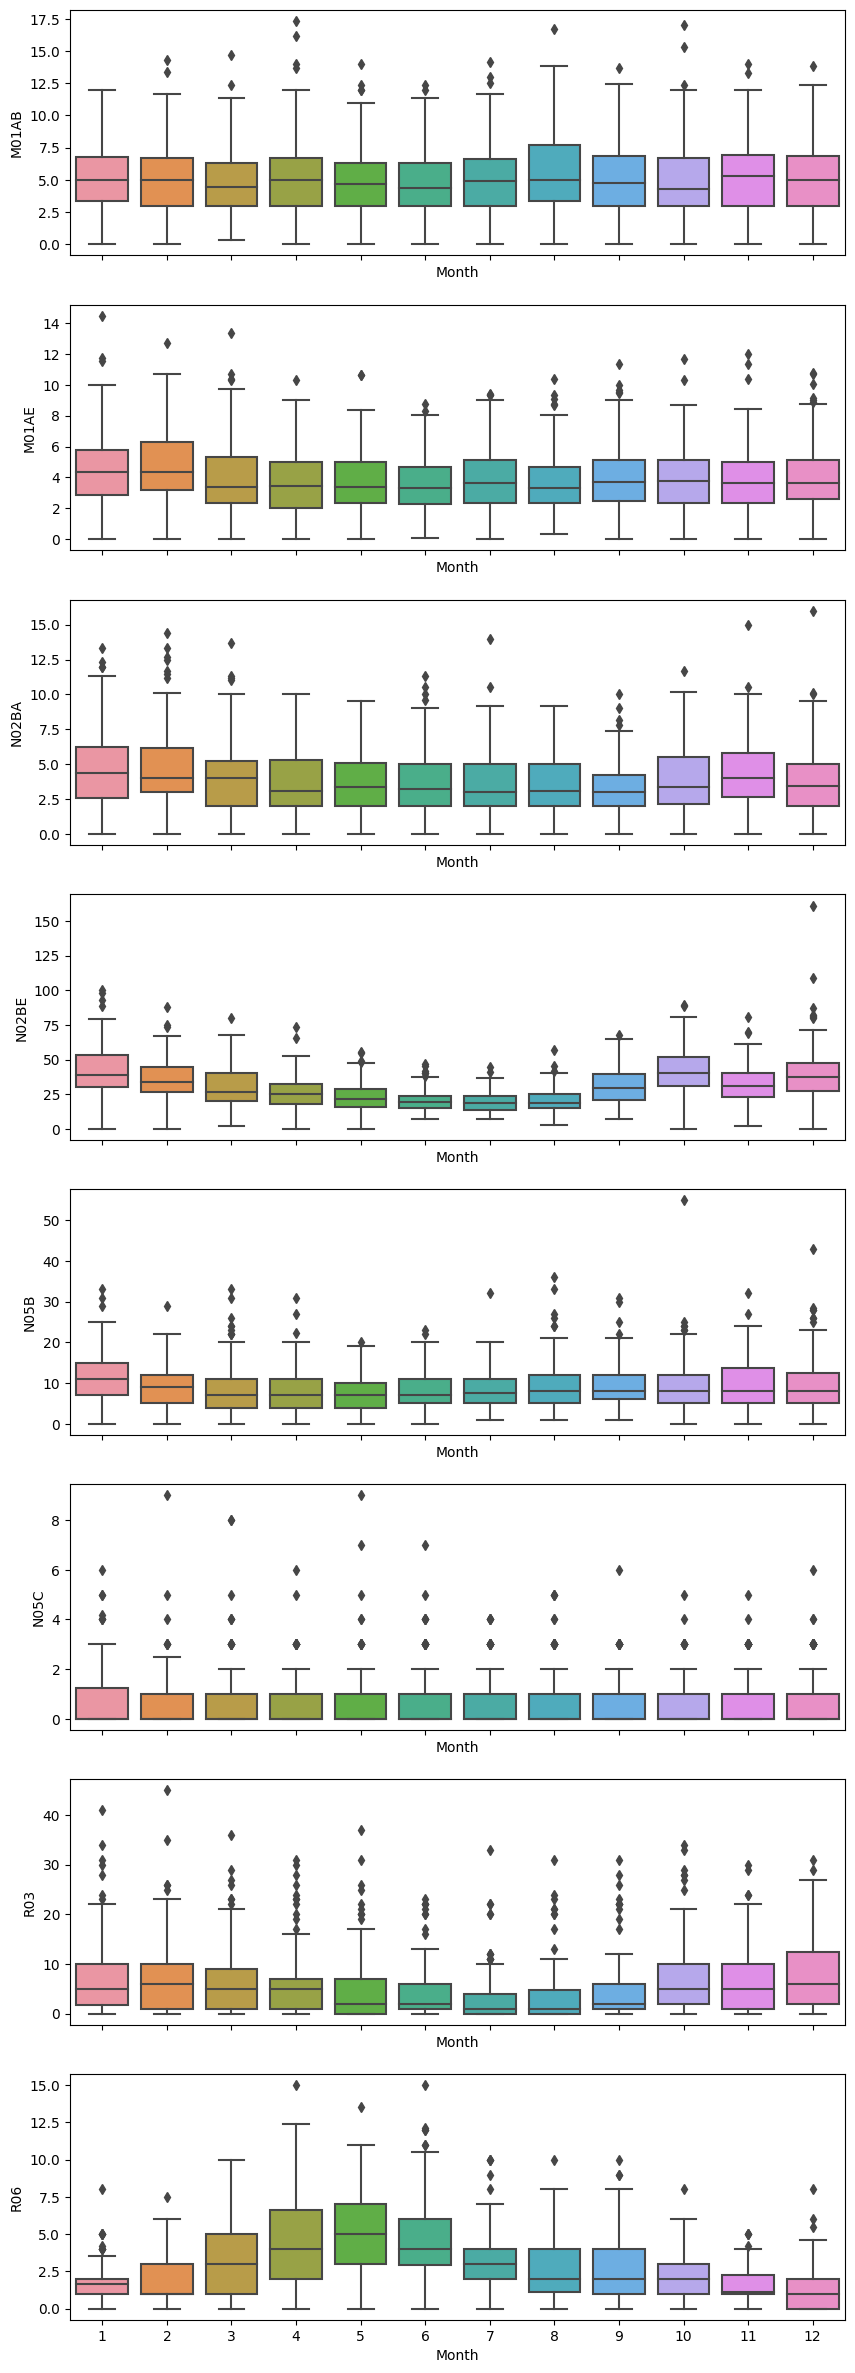

In [12]:
import seaborn as sns
dfatc_daily = pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesdaily.csv')
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Month', y=name, ax=ax)

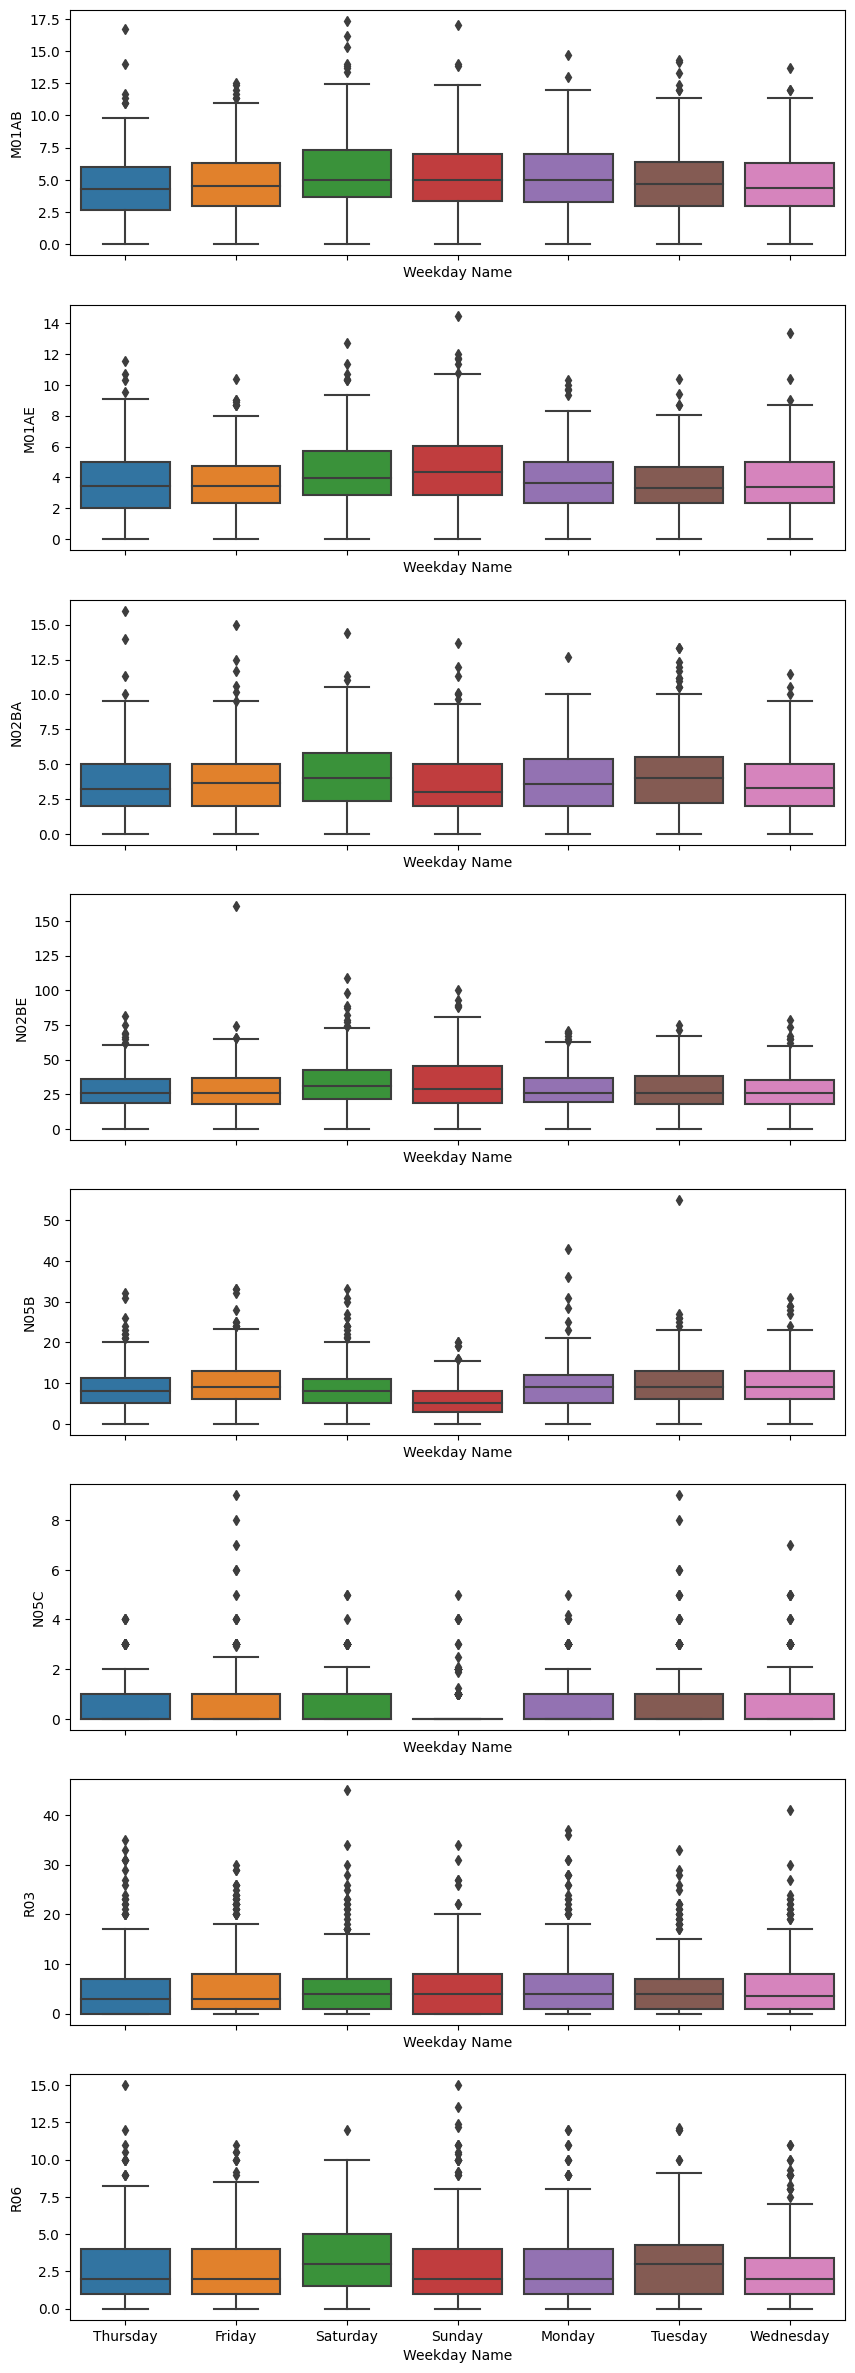

In [13]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=dfatc_daily, x='Weekday Name', y=name, ax=ax)

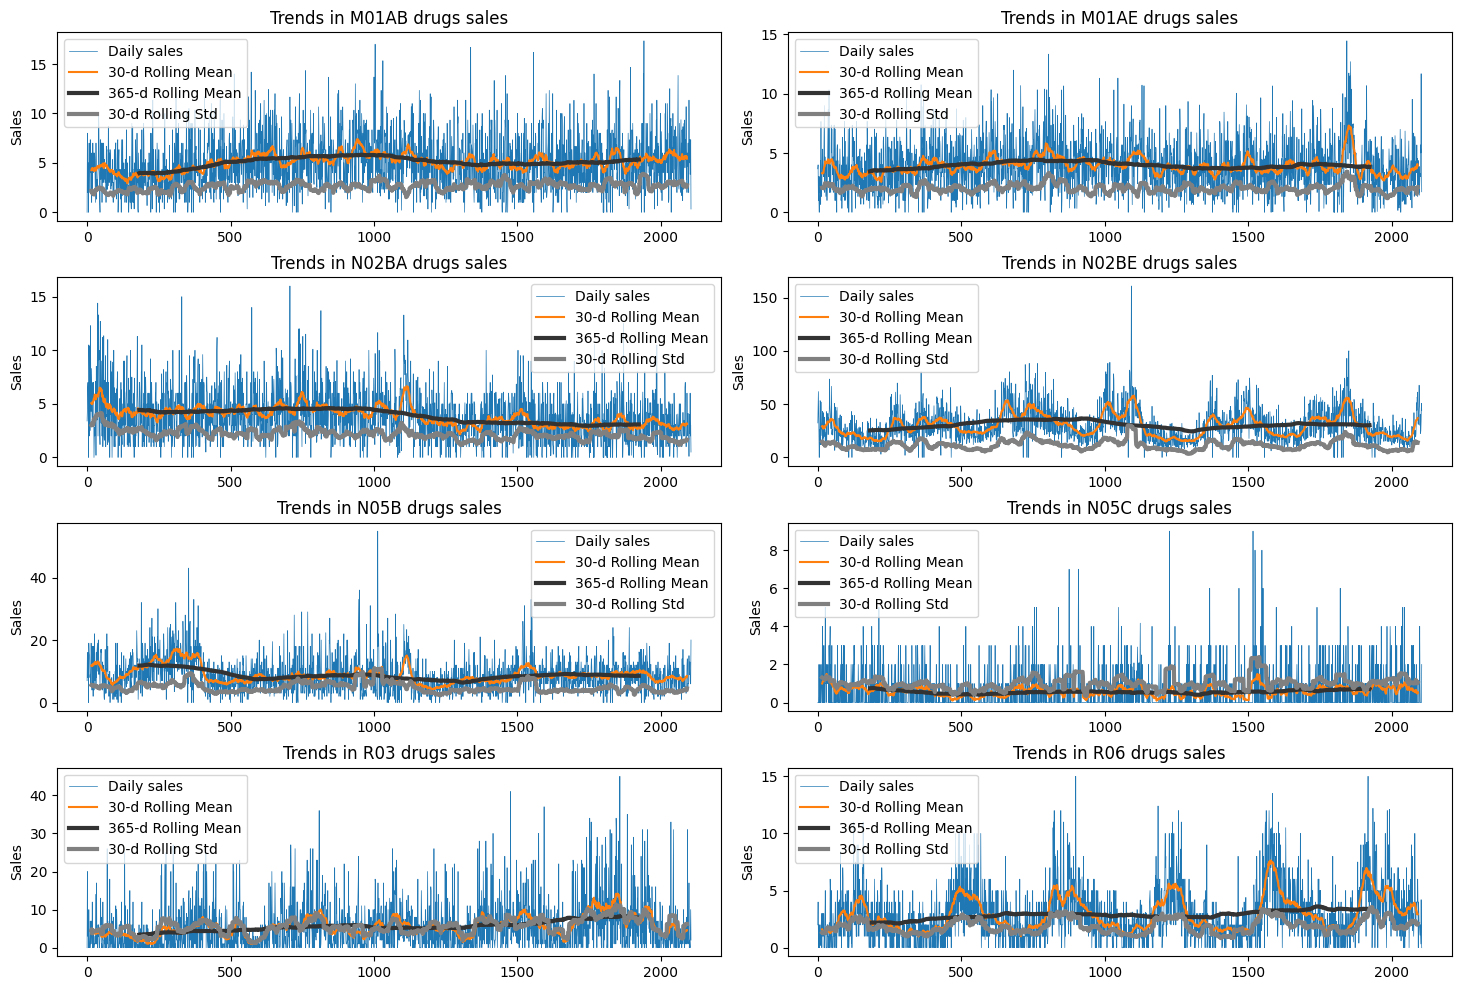

In [14]:
dfatc_daily=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesdaily.csv')
cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');
    subplotindex=subplotindex+1
plt.show()

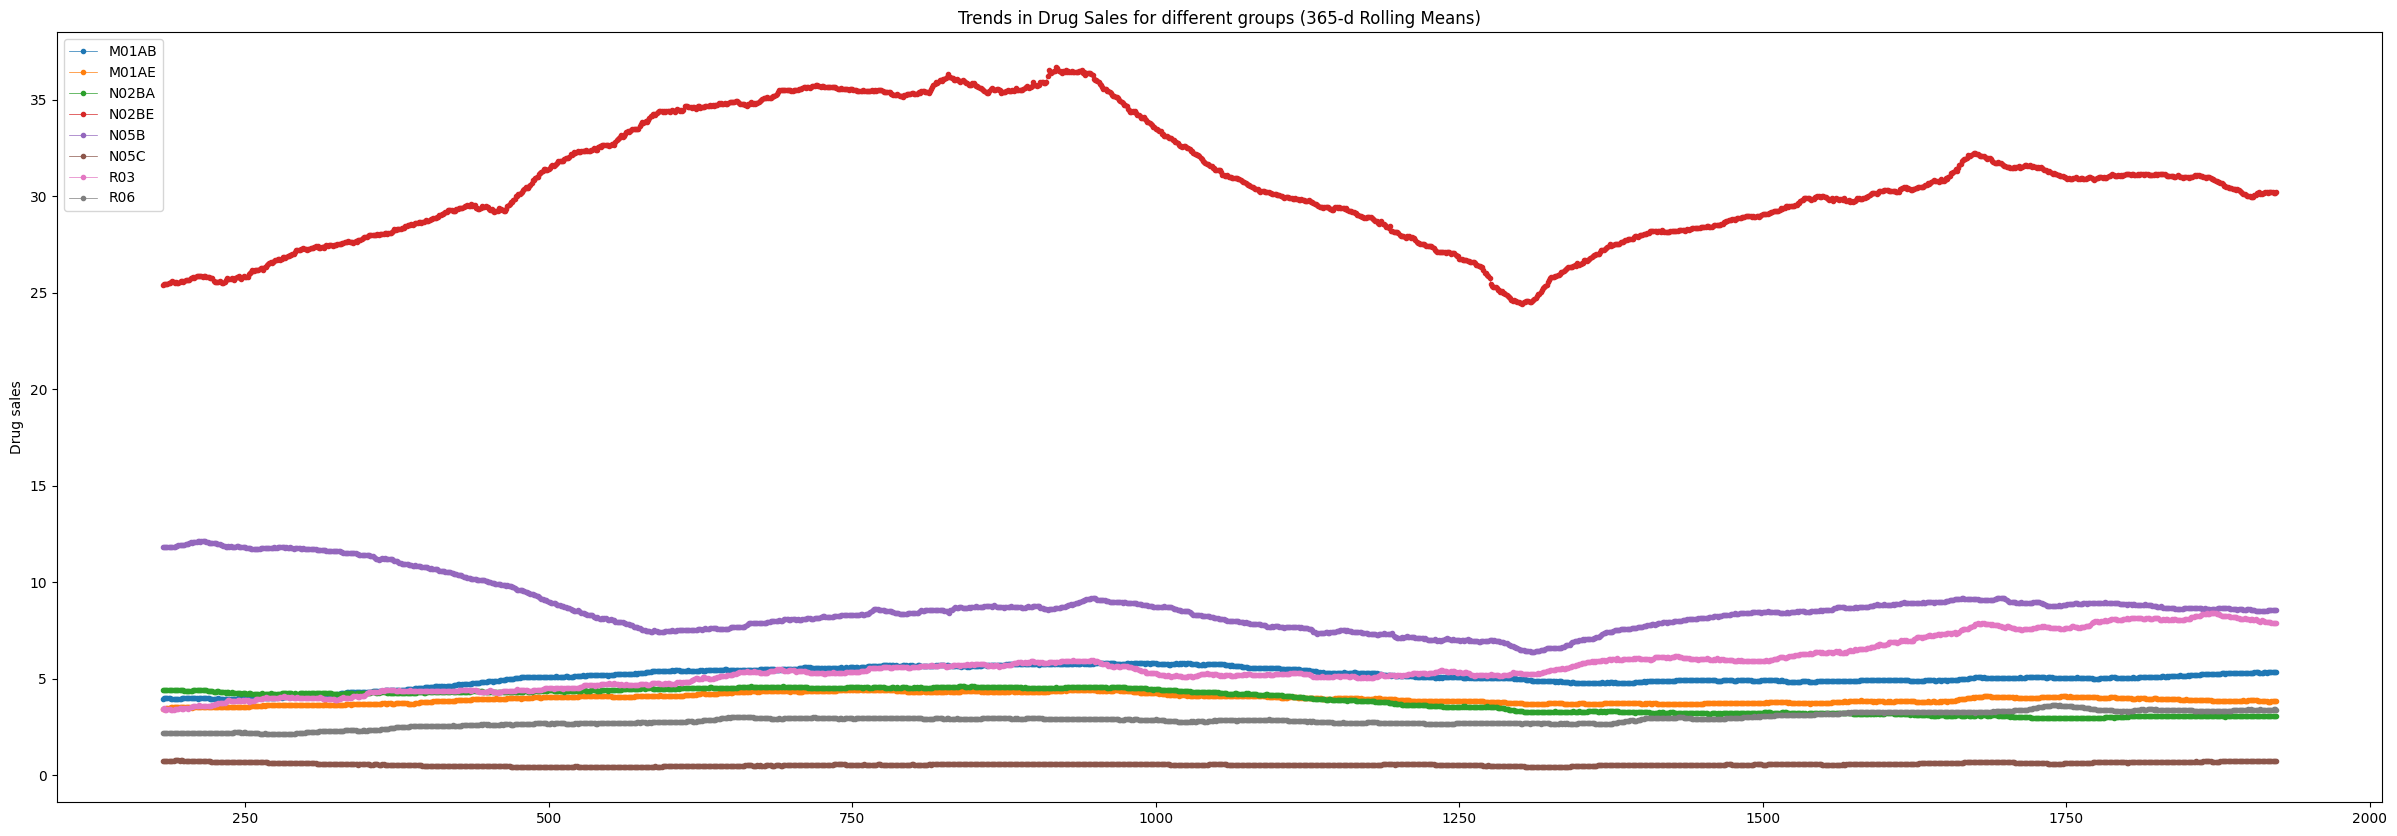

In [15]:
fig, ax = plt.subplots(figsize=(30, 10))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

### Stationarity analysis

In [16]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
from statsmodels.tsa.stattools import adfuller

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for M01AB
-----------------------------
Test statistic = -3.700
P-value = 0.022
Critical values :
	1%: -3.9897903649837616 - The data is not stationary with 99% confidence
	5%: -3.425478311521626 - The data is  stationary with 95% confidence
	10%: -3.1358607194990724 - The data is  stationary with 90% confidence
ADF test for M01AE
-----------------------------
Test statistic = -8.717
P-value = 0.000
Critical values :
	1%: -3.98926783537037 - The data is  stationary with 99% confidence
	5%: -3.425226747185185 - The data is  stationary with 95% confidence
	10%: -3.1357131066666666 - The data is  stationary with 90% confidence
ADF test for N02BA
-----------------------------
Test statistic = -2.670
P-value = 0.249
Critical values :
	1%: -3.990441532957606 - The data is not stationary with 99% confidence
	5%: -3.425791763669738 - The data is not stationary with 95% confidence
	10%: -3.1360446341572343 - The data is not stationary with 90% confidence
ADF test for N02BE
------------

Augmented Dickey-Fuller (ADF) test have shown that all data, but N02BA (P-value=0.249) in the series were stationary, with maximum confidence.

###  Regularity analysis

In [17]:
df = pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

M01AB: 1.141130089570642
M01AE: 1.166363924596575
N02BA: 1.1370638730125302
N02BE: 1.058024809082593
N05B: 1.074437415034502
N05C: 1.0361887401424648
R03: 1.1847216239035152
R06: 1.031759595747876


### Autocorrelation analysis

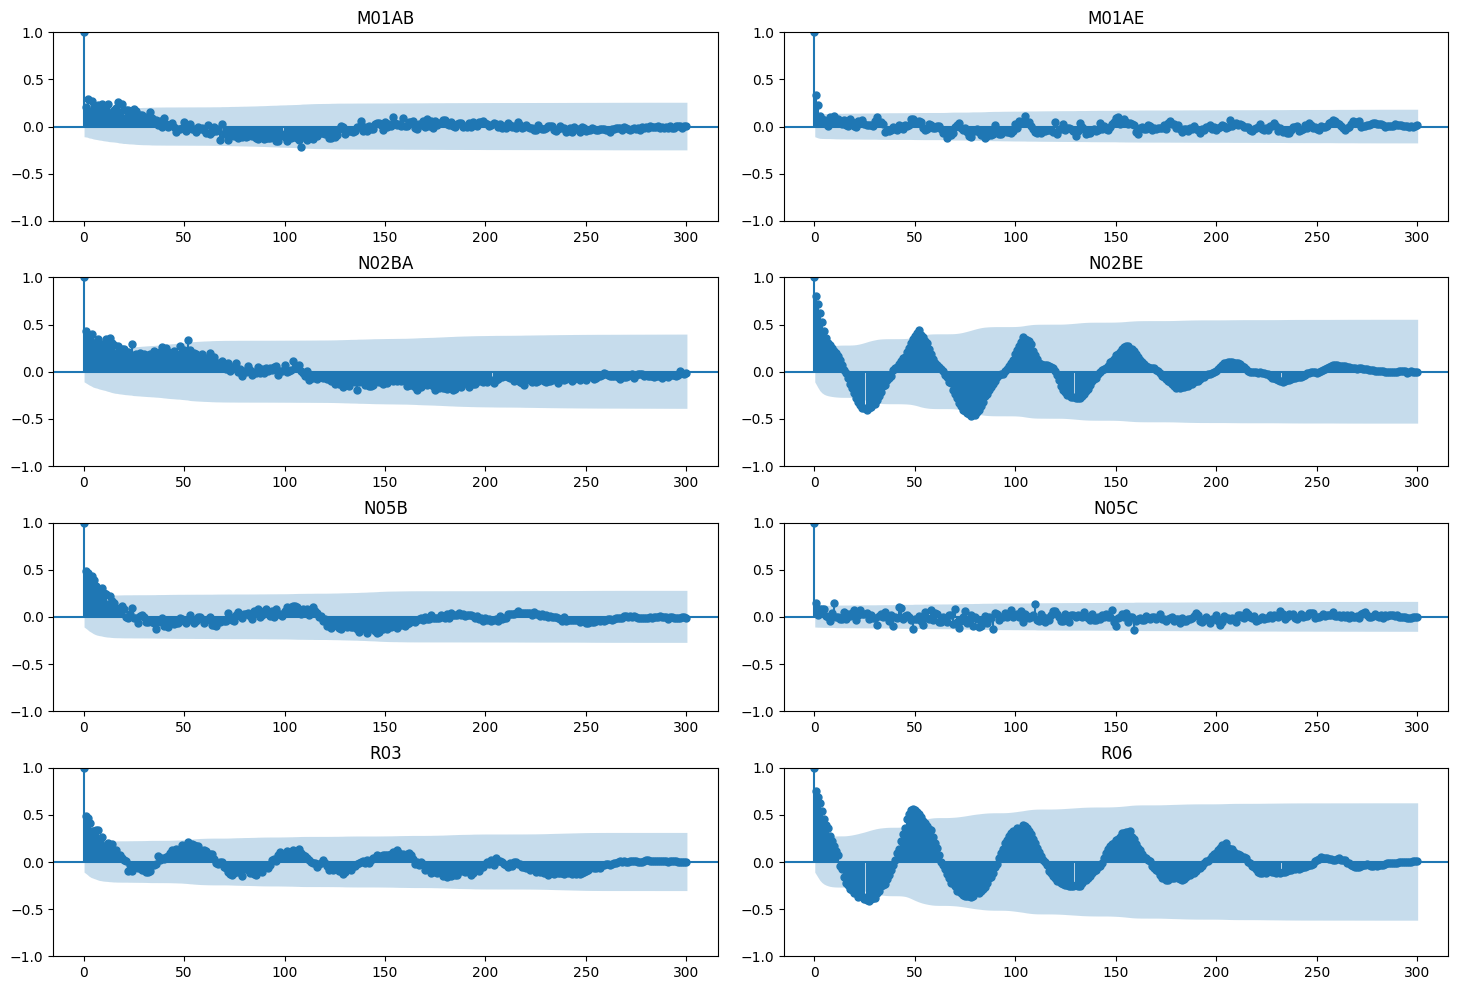

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1


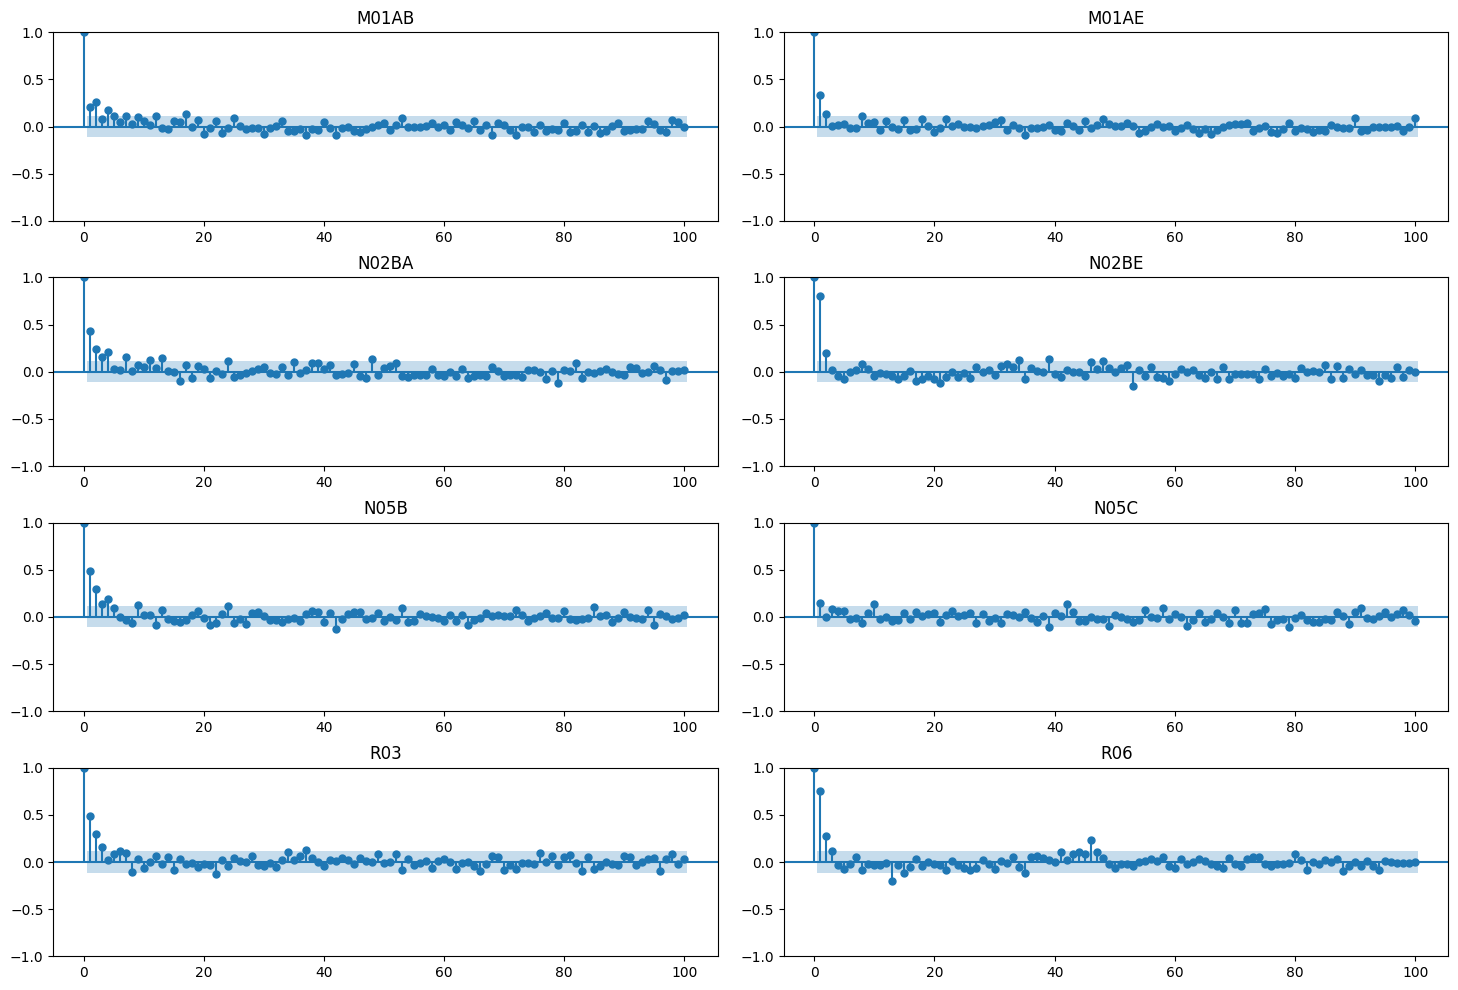

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
df = pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

### 4.2.5. Data distribution analysis

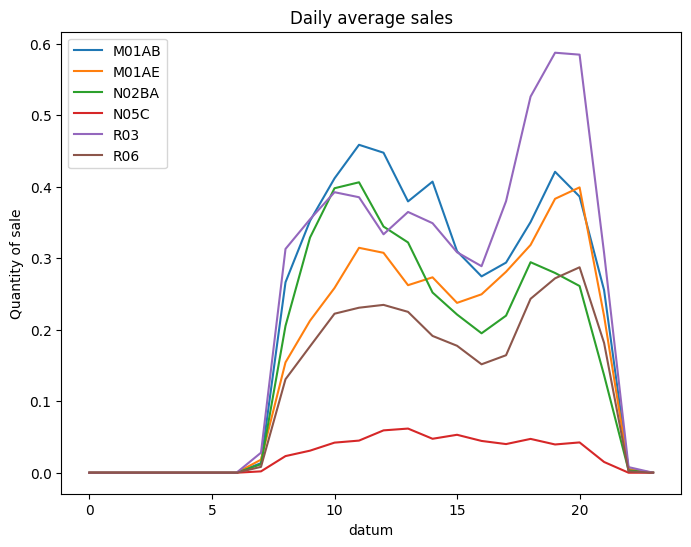

In [20]:
dfatch=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/saleshourly.csv')
dfatch['datum']= pd.to_datetime(dfatch['datum'])

grp1=dfatch.groupby(dfatch.datum.dt.hour)['M01AB'].mean()
grp2=dfatch.groupby(dfatch.datum.dt.hour)['M01AE'].mean()
grp3=dfatch.groupby(dfatch.datum.dt.hour)['N02BA'].mean()
grp6=dfatch.groupby(dfatch.datum.dt.hour)['N05C'].mean()
grp7=dfatch.groupby(dfatch.datum.dt.hour)['R03'].mean()
grp8=dfatch.groupby(dfatch.datum.dt.hour)['R06'].mean()

plt.title('Daily average sales')
plt.xlabel('Time of day')
plt.ylabel('Quantity of sale')

grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper left')

plt.show()

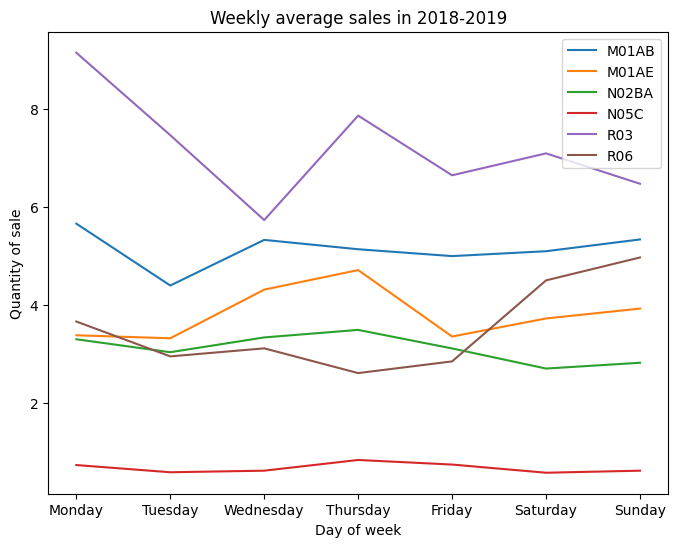

In [21]:
dfatcw=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesdaily.csv')
dfatcw['datum']= pd.to_datetime(dfatcw['datum'])
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
plt.rcParams.update({'font.size': 10})

grp1=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['M01AB'].mean().reindex(days)
grp2=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['M01AE'].mean().reindex(days)
grp3=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['N02BA'].mean().reindex(days)
grp6=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['N05C'].mean().reindex(days)
grp7=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['R03'].mean().reindex(days)
grp8=dfatcw.loc[dfatcw.datum>'2018-01-01'].groupby(dfatch.datum.dt.day_name())['R06'].mean().reindex(days)

grp1.plot(figsize=(8,6))
grp2.plot(figsize=(8,6))
grp3.plot(figsize=(8,6))
grp6.plot(figsize=(8,6))
grp7.plot(figsize=(8,6))
grp8.plot(figsize=(8,6))

plt.legend(['M01AB', 'M01AE', 'N02BA', 'N05C', 'R03', 'R06'], loc='upper right')
plt.title('Weekly average sales in 2018-2019')
plt.xlabel('Day of week')
plt.ylabel('Quantity of sale')

plt.show()

##  Time series forecasting

In [22]:
resultsRolling={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE',
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE',
                         'Prophet MSE', 'Prophet MAPE']
resultsLongterm={'M01AB':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'M01AE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BA':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N02BE':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05B':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'N05C':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R03':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'R06':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE',
                           'AutoARIMA MSE', 'AutoARIMA MAPE', 'Prophet MSE', 'Prophet MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

### Baseline forecasting accuracy

####  Naïve forecasting

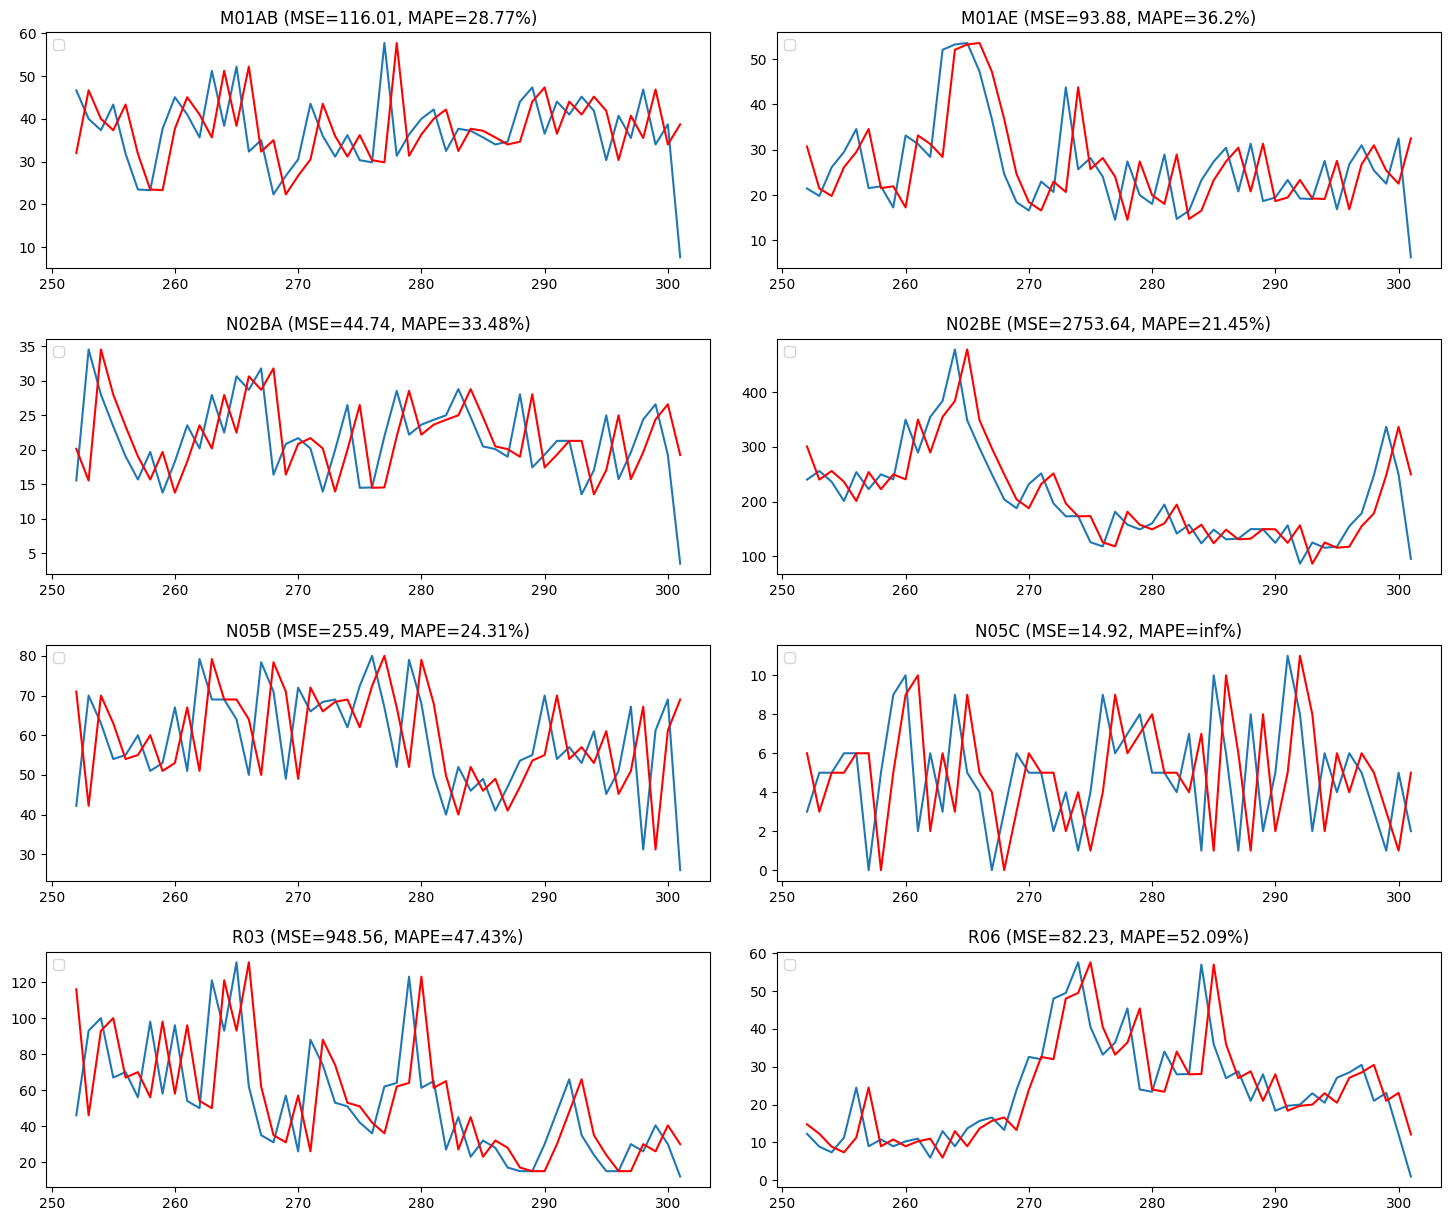

In [23]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

####
 Average method forecasting

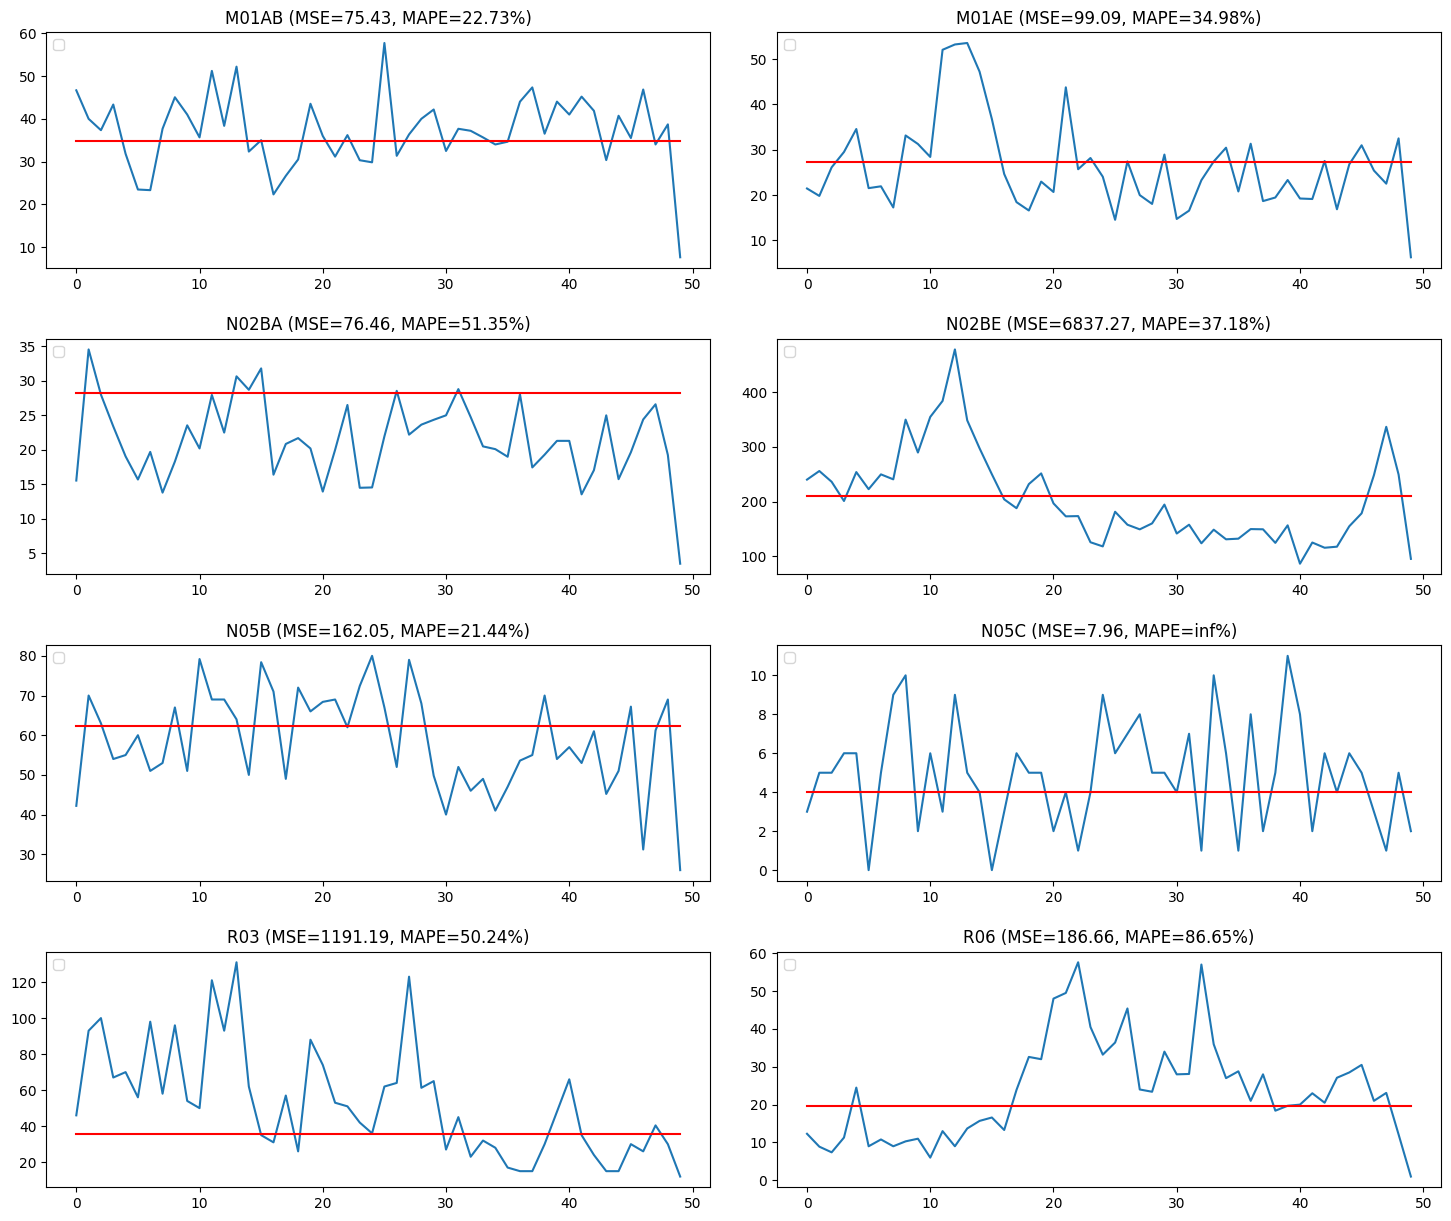

In [24]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)]
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### Seasonal Naïve forecasting

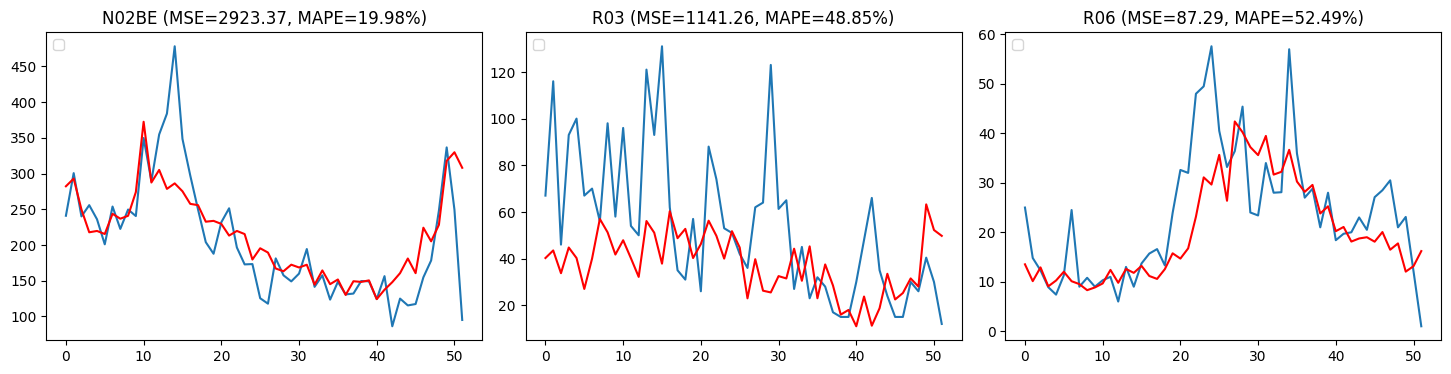

In [25]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
subplotindex=0
numrows=1
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['N02BE','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-52
    test = X[size:len(X)]
    train = X[0:size]
    predictions=list()
    history = [x for x in train]
    for i in range(len(test)):
        obs=list()
        for y in range(1,5):
            obs.append(train[-(y*52)+i])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Seasonal Naive MSE',x]=error
    resultsRollingdf.loc['Seasonal Naive MAPE',x]=perror
    ax[colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[colindex].plot(test)
    ax[colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

###  ARIMA Forecasting

#### Choosing parameters for ARIMA model

In [26]:
import statsmodels.api as sm
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
warnings.filterwarnings("ignore")
for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q,M01AB) = (3, 3) is the best.
ARMA(p,q,M01AE) = (2, 0) is the best.
ARMA(p,q,N02BA) = (3, 3) is the best.
ARMA(p,q,N02BE) = (2, 2) is the best.
ARMA(p,q,N05B) = (4, 3) is the best.
ARMA(p,q,N05C) = (3, 2) is the best.
ARMA(p,q,R03) = (1, 1) is the best.
ARMA(p,q,R06) = (2, 2) is the best.


In [27]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMANone MSE=inf
M01AE - Best ARIMANone MSE=inf
N02BA - Best ARIMANone MSE=inf
N02BE - Best ARIMANone MSE=inf
N05B - Best ARIMANone MSE=inf
N05C - Best ARIMANone MSE=inf
R03 - Best ARIMANone MSE=inf
R06 - Best ARIMANone MSE=inf


In [28]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) - 50)
    train, test = X[0:train_size], X[train_size:]
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMA(0, 0, 0) MSE=75.429
M01AE - Best ARIMA(4, 0, 4) MSE=98.448
N02BA - Best ARIMA(0, 0, 0) MSE=76.461
N02BE - Best ARIMA(0, 0, 0) MSE=6837.270
N05B - Best ARIMA(0, 0, 0) MSE=162.051
N05C - Best ARIMA(1, 0, 2) MSE=7.528
R03 - Best ARIMA(0, 0, 0) MSE=1191.187
R06 - Best ARIMA(4, 0, 4) MSE=161.180


#### 4.3.2.2. Rolling forecasting with ARIMA model

In [29]:
from statsmodels.tsa.arima.model import ARIMA

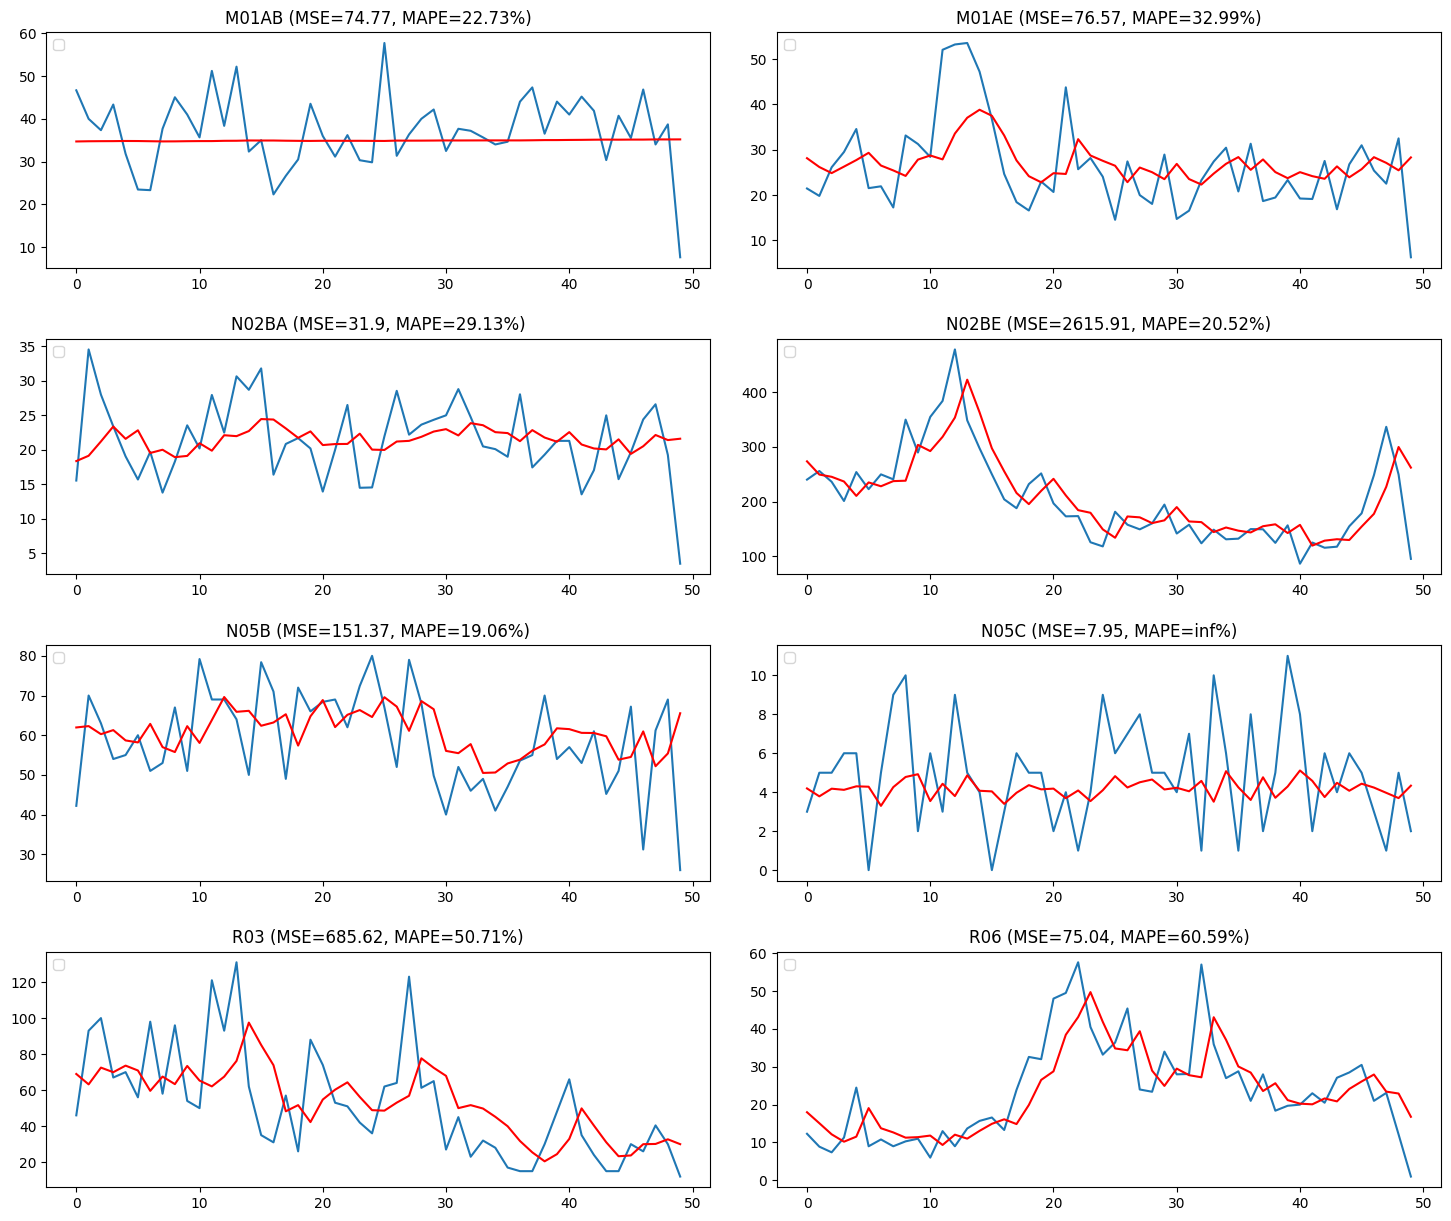

In [30]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')

M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':2,'d':0,'q':0}
N02BA= {'series':'N02BA','p':5,'d':1,'q':1}
N02BE= {'series':'N02BE','p':2,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':5}
N05C= {'series':'N05C','p':0,'d':0,'q':1}
R03= {'series':'R03','p':5,'d':1,'q':1}
R06= {'series':'R06','p':1,'d':0,'q':1}

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = smapi.tsa.arima.ARIMA(history, order=(x['p'],x['d'],x['q']))
        result = model.fit()
        output = result.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['ARIMA MSE',x['series']]=error
    resultsRollingdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

####  Long-term forecasting with ARIMA model

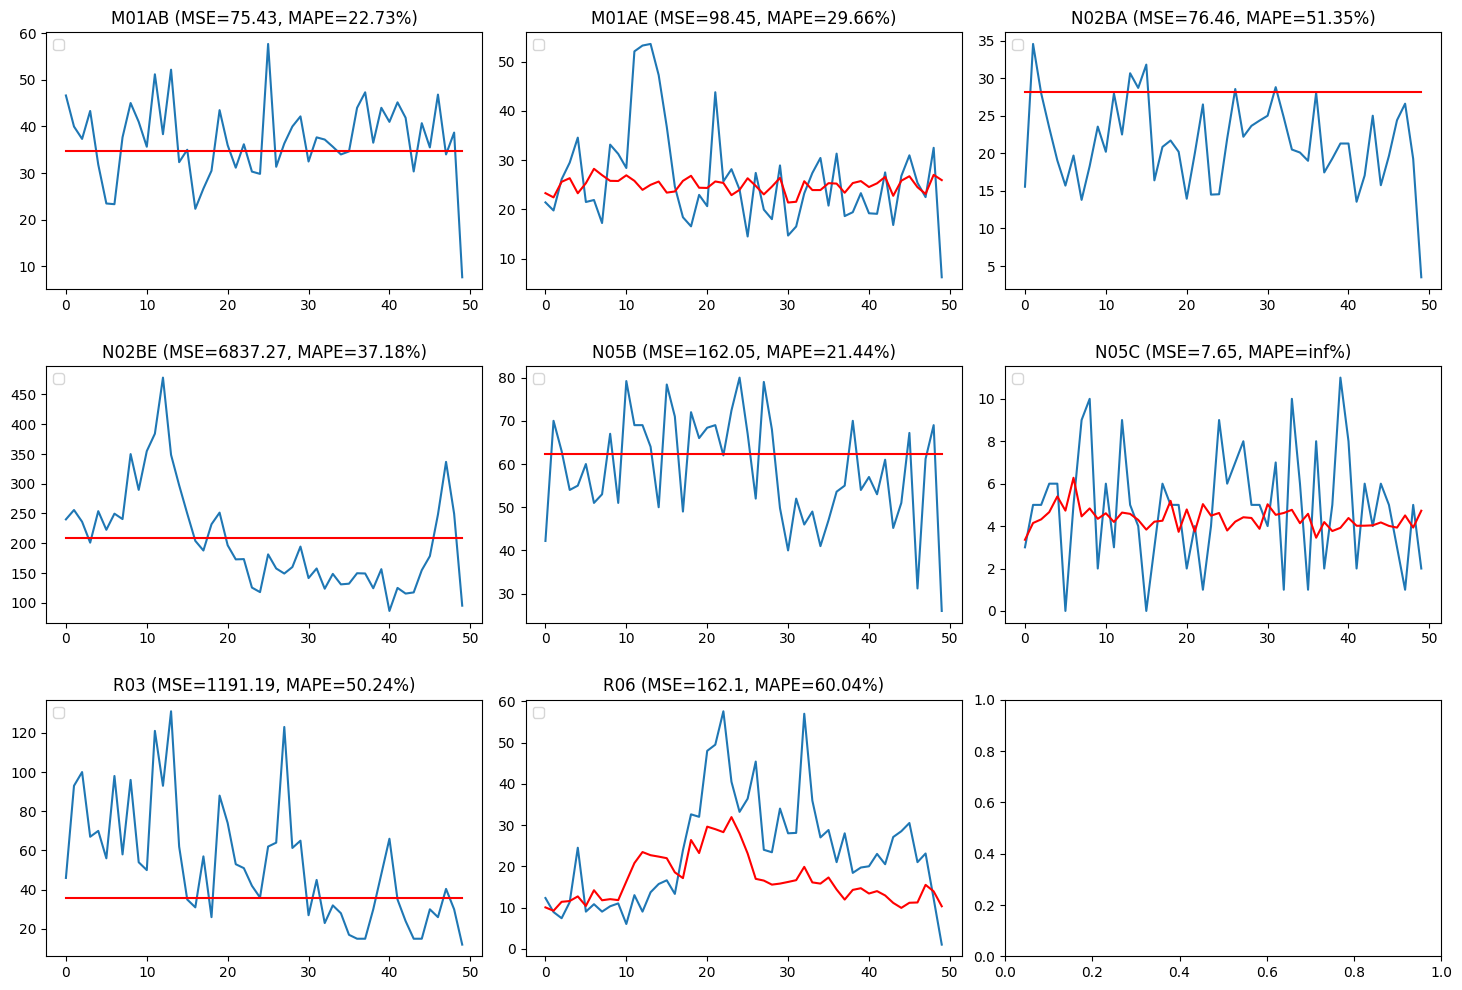

In [31]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')

M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':4,'d':0,'q':4}
N02BA= {'series':'N02BA','p':0,'d':0,'q':0}
N02BE= {'series':'N02BE','p':0,'d':0,'q':0}
N05B= {'series':'N05B','p':0,'d':0,'q':0}
N05C= {'series':'N05C','p':2,'d':0,'q':2}
R03= {'series':'R03','p':0,'d':0,'q':0}
R06= {'series':'R06','p':2,'d':0,'q':2}

subplotindex=0
numrows=3
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    model = ARIMA(train, order=(x['p'],x['d'],x['q']))
    model_fit = model.fit()
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, forecast)
    resultsLongtermdf.loc['ARIMA MSE',x['series']]=error
    resultsLongtermdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

#### Rolling forecasting with Auto-ARIMA model

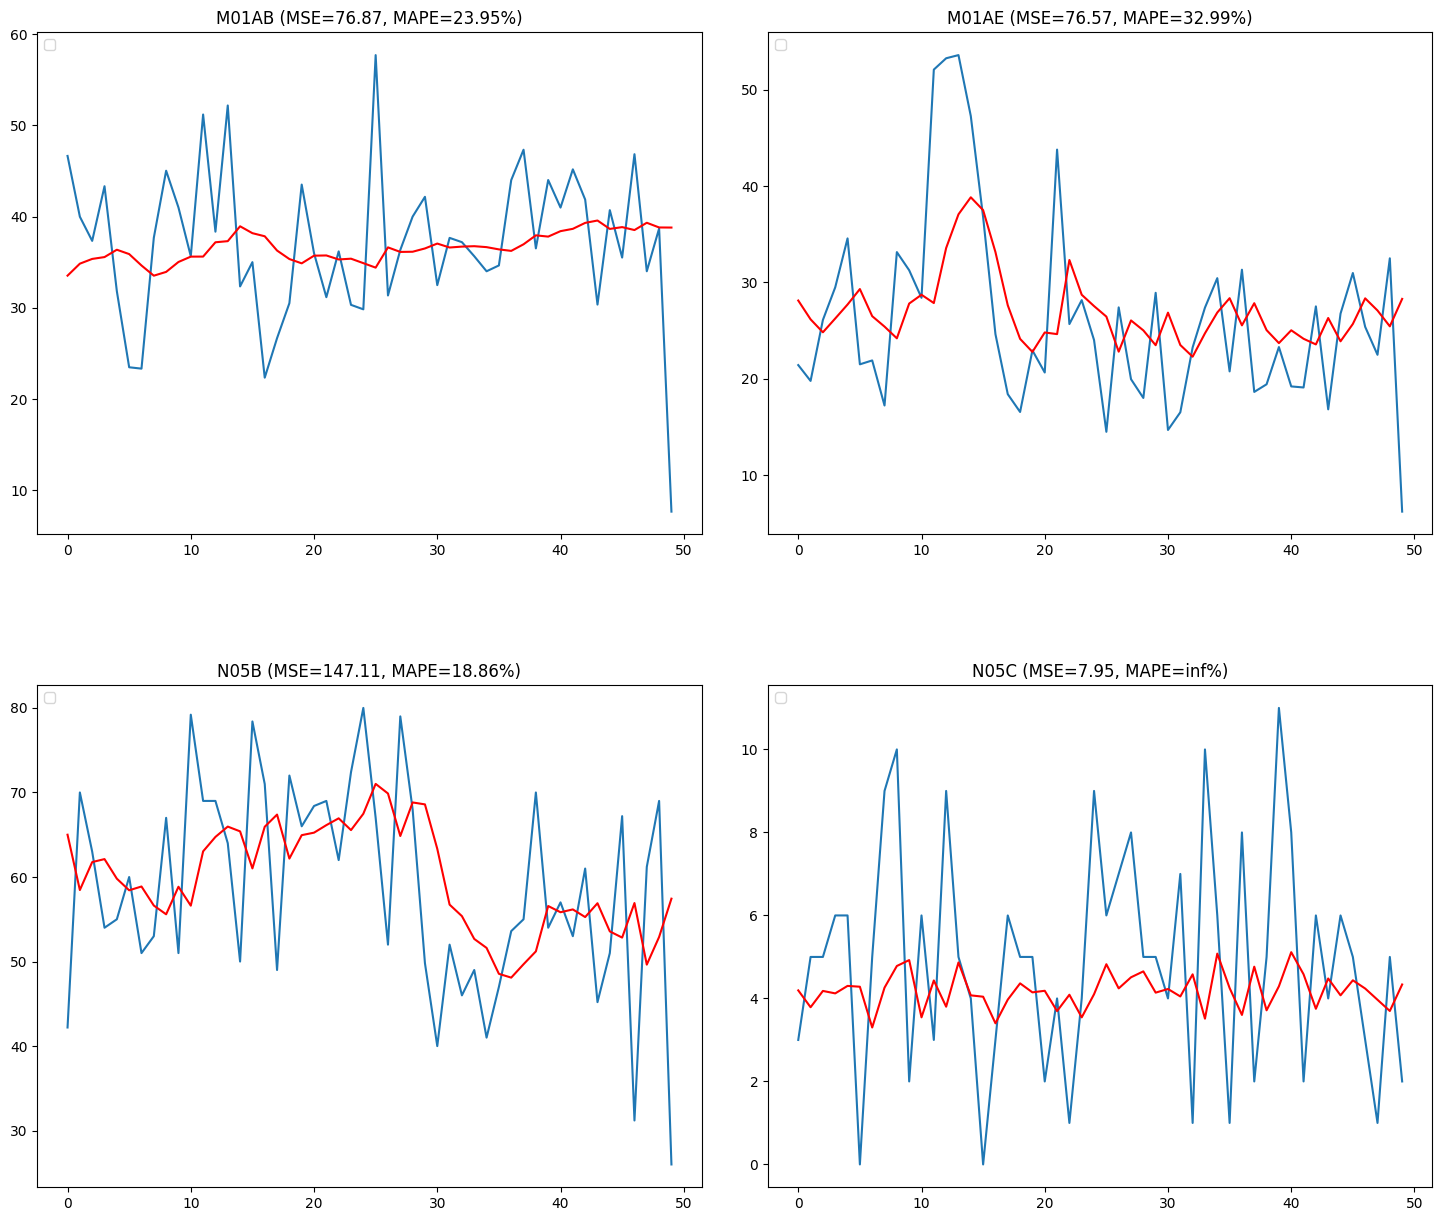

In [32]:
from pmdarima.arima import auto_arima

df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
subplotindex=0
numrows=2
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N05B','N05C']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [c for c in train]
    predictions = list()
    for t in range(len(test)):
        if (x=='N02BA' or x=='N02BE' or x=='R03' or x=='R06'):
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
        else:
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
        model_fit = model.fit(history)
        output = model_fit.predict(n_periods=1)
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['AutoARIMA MSE',x]=error
    resultsRollingdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

#### Long-term forecasting with Auto-ARIMA model

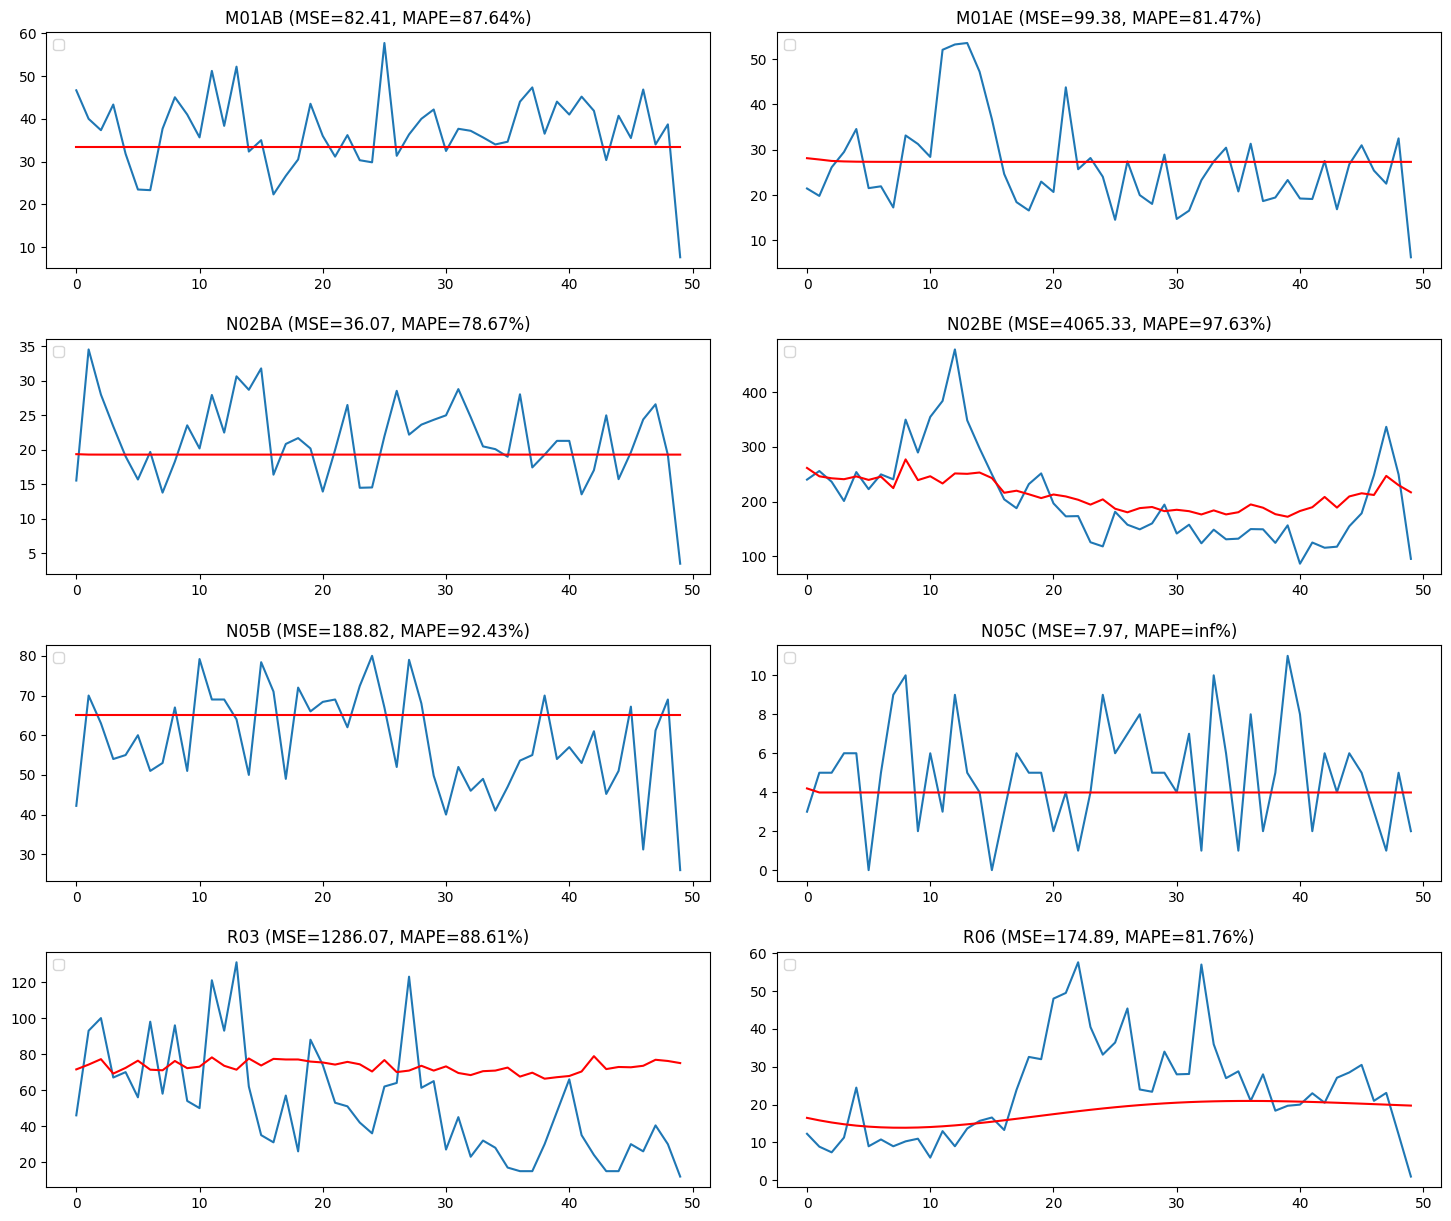

In [33]:
from pmdarima.arima import auto_arima

df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    if (x=='N02BE' or x=='R03' or x=='R06'):
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    else:
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)
    model_fit = model.fit(train)
    forecast = model_fit.predict(n_periods=len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['AutoARIMA MSE',x]=error
    resultsLongtermdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

####  Grid-search optimization of Prophet hyper-parameters

In [34]:
!pip install prophet

In [35]:
import prophet

In [36]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')

M01AB= {
    'series':'M01AB',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[10,30,50],
               'interval_width':[0.0005]
              }
}
M01AE= {
    'series':'M01AE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],
               'interval_width':[0.0005]
              }
}
N02BA= {
    'series':'N02BA',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.005,0.01,0.05,0.1],
                   'interval_width':[0.0005]
              }
}
N02BE= {
    'series':'N02BE',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[5,10,50],'seasonality_prior_scale':[150,170,200],
               'interval_width':[0.0005]
              }
}
N05B= {
    'series':'N05B',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[1,5,10],
               'interval_width':[0.0005]
              }
}
N05C= {
    'series':'N05C',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.05,0.08,0.1,0.5],
               'interval_width':[0.0005]
              }
}
R03= {
    'series':'R03',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[120,160,200],
               'interval_width':[0.0005]
              }
}
R06= {
    'series':'R06',
    'params_grid':{'growth':['linear'],'changepoint_prior_scale':[0.01,0.05,0.1],'seasonality_prior_scale':[100,120,160,200],
               'interval_width':[0.0005]
              }
}

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]
warnings.filterwarnings("ignore")

for x in r:
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    minError=0
    grid = ParameterGrid(x['params_grid'])
    for p in grid:
        model = prophet.Prophet(**p, daily_seasonality=False, weekly_seasonality=False)
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                fourier_order=13)
        model_fit = model.fit(dfgtrain)
        future = model.make_future_dataframe(periods=50, freq='W')
        output = model.predict(future)
        predictions=output.loc[size+2:len(dfg),:]['yhat'].values
        error = mean_squared_error(dfgtest['y'].values, predictions)
        if(minError>0):
            if(error<minError):
                minError=error
                minP=p
        else:
            minError=error
            minP=p

    print(minP)
    print('Test MSE ('+x['series']+'): %.3f' % minError)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/w8clj6_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/pbnn45e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59698', 'data', 'file=/tmp/tmpclw_9aca/w8clj6_z.json', 'init=/tmp/tmpclw_9aca/pbnn45e1.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_modelhg7ok0aw/prophet_model-20231103162138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/hnowc19q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/ip418__f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 30, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (M01AB): 69.659


DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/eojvaqar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/673o1p07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58651', 'data', 'file=/tmp/tmpclw_9aca/eojvaqar.json', 'init=/tmp/tmpclw_9aca/673o1p07.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_modelergsqk1i/prophet_model-20231103162139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/u82mgafo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/i1802ri5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (M01AE): 79.585


DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/yrcb2xcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/8wfge57u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26730', 'data', 'file=/tmp/tmpclw_9aca/yrcb2xcj.json', 'init=/tmp/tmpclw_9aca/8wfge57u.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_model5eozmljj/prophet_model-20231103162140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/w0jtsww0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/n2hy3xvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

{'changepoint_prior_scale': 0.01, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N02BA): 32.260


16:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/c9hn1auw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/92xz_4xs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39963', 'data', 'file=/tmp/tmpclw_9aca/c9hn1auw.json', 'init=/tmp/tmpclw_9aca/92xz_4xs.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_modelsc0a8nus/prophet_model-20231103162141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearl

{'changepoint_prior_scale': 10, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 170}
Test MSE (N02BE): 3079.240


16:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/eoy8cd6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/x3m9ctif.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1006', 'data', 'file=/tmp/tmpclw_9aca/eoy8cd6m.json', 'init=/tmp/tmpclw_9aca/x3m9ctif.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_modelo3zxwsck/prophet_model-20231103162145.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/4y2mfh55.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/uyfrs_if.json
DEBUG:cmdstanpy:idx 

{'changepoint_prior_scale': 5, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N05B): 305.309


DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/nfmub7x8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/fx99y53m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1834', 'data', 'file=/tmp/tmpclw_9aca/nfmub7x8.json', 'init=/tmp/tmpclw_9aca/fx99y53m.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_modelssy9b1rm/prophet_model-20231103162147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/9e1e9q8u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/3gsxlruu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

{'changepoint_prior_scale': 0.5, 'growth': 'linear', 'interval_width': 0.0005}
Test MSE (N05C): 8.375


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/fux70001.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/rg4v3g_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30379', 'data', 'file=/tmp/tmpclw_9aca/fux70001.json', 'init=/tmp/tmpclw_9aca/rg4v3g_i.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_modelxorwhxfd/prophet_model-20231103162149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/scj

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 160}
Test MSE (R03): 837.148


16:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/jl1patpi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/dyybf57j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30175', 'data', 'file=/tmp/tmpclw_9aca/jl1patpi.json', 'init=/tmp/tmpclw_9aca/dyybf57j.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_modelag_1rik4/prophet_model-20231103162152.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Found custom seasonality named 'yearl

{'changepoint_prior_scale': 0.05, 'growth': 'linear', 'interval_width': 0.0005, 'seasonality_prior_scale': 120}
Test MSE (R06): 76.725


####  Rolling forecasts with Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/ehu78s4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/oho4rpcj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4752', 'data', 'file=/tmp/tmpclw_9aca/ehu78s4q.json', 'init=/tmp/tmpclw_9aca/oho4rpcj.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_model34qz7npx/prophet_model-20231103162157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:21:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/g1pjy4sb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/9yfhf5_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

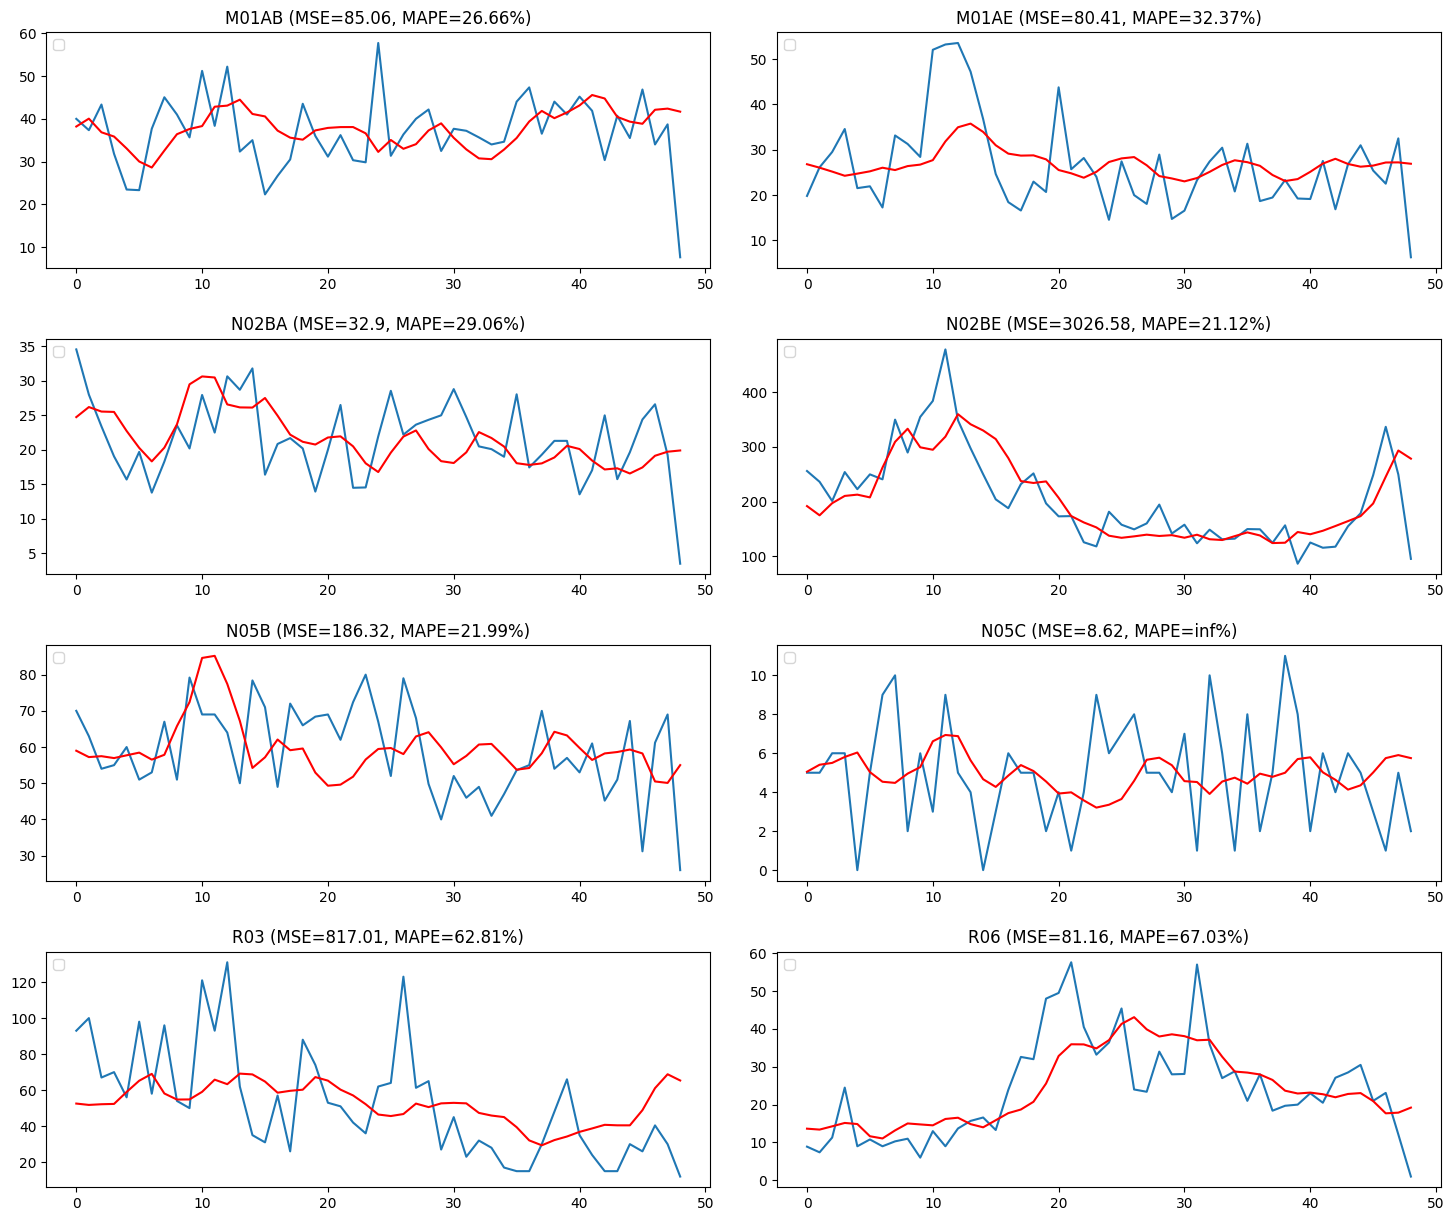

In [37]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

M01AB= {'series':'M01AB','params_grid':{'changepoint_prior_scale':30,'interval_width':0.0005}}
M01AE= {'series':'M01AE','params_grid':{'changepoint_prior_scale':0.05,'interval_width':0.0005}}
N02BA= {'series':'N02BA','params_grid':{'changepoint_prior_scale':0.005,'interval_width':0.0005}}
N02BE= {'series':'N02BE','params_grid':{'changepoint_prior_scale':10,'seasonality_prior_scale':170,'interval_width':0.0005}}
N05B= {'series':'N05B','params_grid':{'changepoint_prior_scale':5,'interval_width':0.0005}}
N05C= {'series':'N05C','params_grid':{'changepoint_prior_scale':0.5,'interval_width':0.005}}
R03= {'series':'R03','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':160,'interval_width':0.0005}}
R06= {'series':'R06','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':120,'interval_width':0.0005}}

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]

for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = len(dfg) - 50
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    history = dfgtrain.copy()
    predictions = list()

    for t in dfgtest['ds'].values:
        model = prophet.Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                                  growth='linear',
                                  interval_width=x['params_grid']['interval_width'],
                                  daily_seasonality=False,
                                  weekly_seasonality=False
                           )
        if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
            model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
        model_fit = model.fit(history)
        future = model.make_future_dataframe(periods=1, freq='W')
        output = model.predict(future)
        yhat = output.loc[output.ds==t]['yhat'].values[0]
        predictions.append(yhat)
        obs = dfgtest.loc[dfgtest.ds==t]['y'].values[0]
        dd=pd.DataFrame([[t,obs]],columns=['ds','y'])
        history=history.append(dd)

    error = mean_squared_error(dfgtest['y'].values, predictions)
    perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsRollingdf.loc['Prophet MSE',x['series']]=error
    resultsRollingdf.loc['Prophet MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

####  Long-term forecasting with Prophet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/79yslc7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/axezzv4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44912', 'data', 'file=/tmp/tmpclw_9aca/79yslc7m.json', 'init=/tmp/tmpclw_9aca/axezzv4x.json', 'output', 'file=/tmp/tmpclw_9aca/prophet_modeljkzmbm20/prophet_model-20231103162437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/js34m3yq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpclw_9aca/jzb90lss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

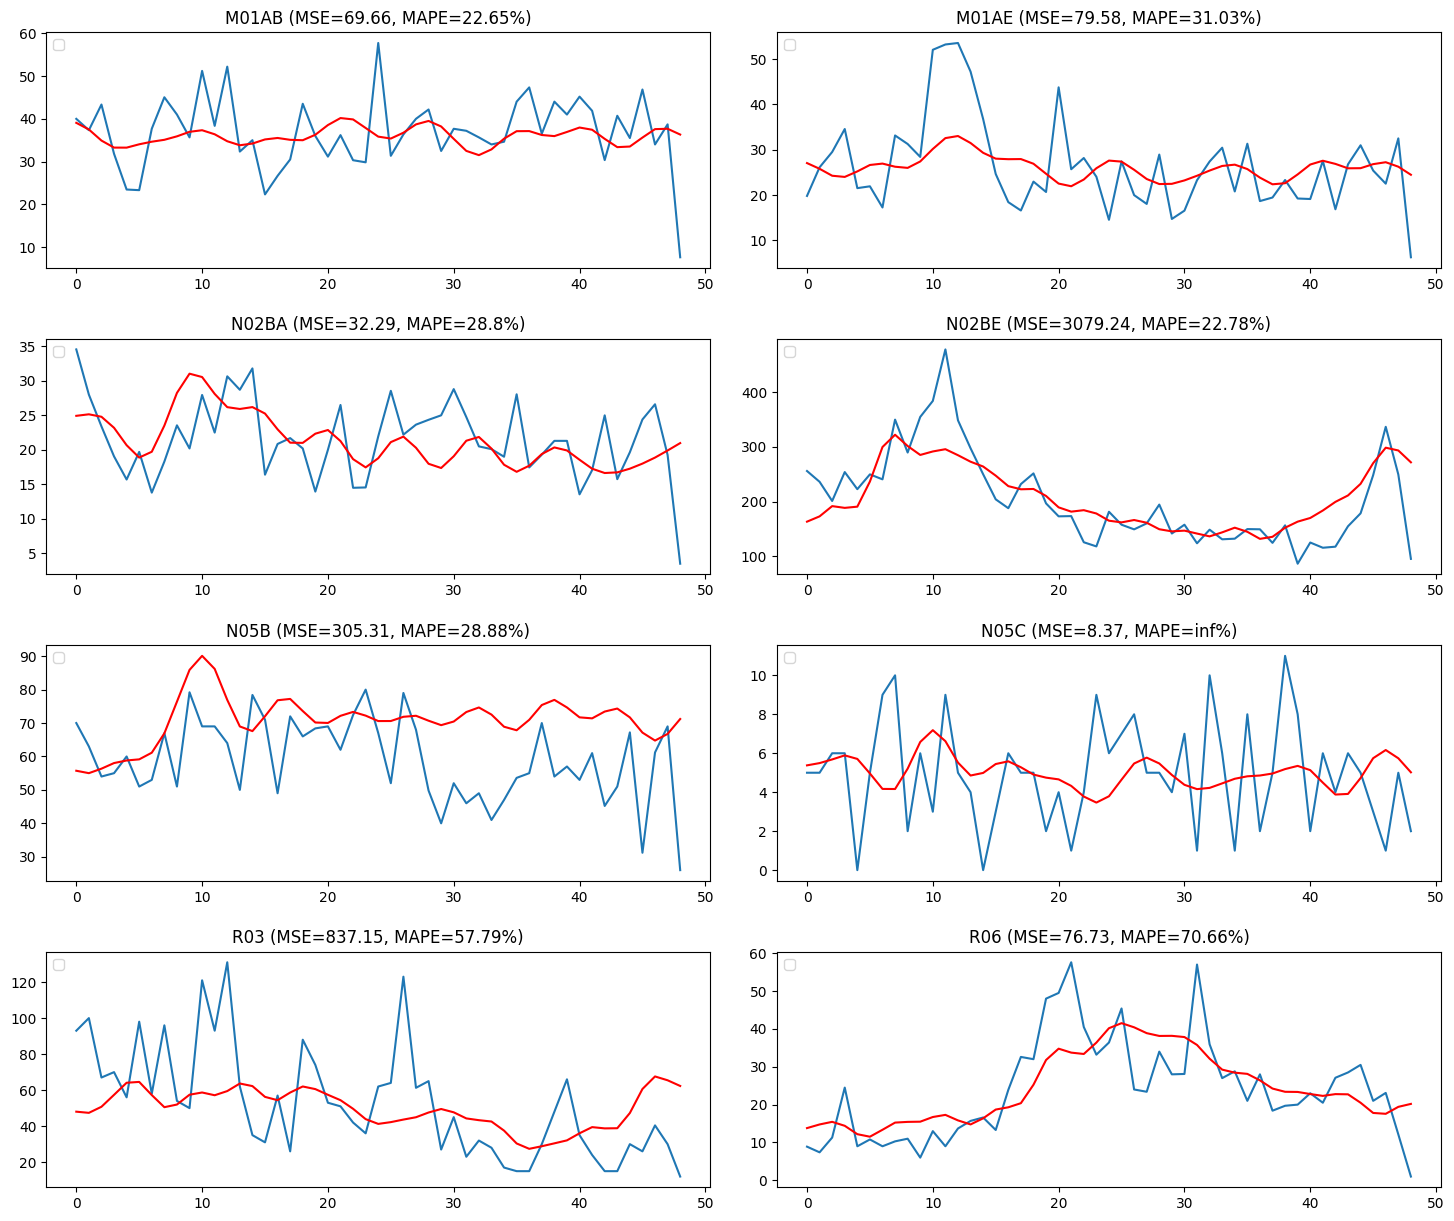

In [38]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

M01AB= {'series':'M01AB','params_grid':{'changepoint_prior_scale':30,'interval_width':0.0005}}
M01AE= {'series':'M01AE','params_grid':{'changepoint_prior_scale':0.05,'interval_width':0.0005}}
N02BA= {'series':'N02BA','params_grid':{'changepoint_prior_scale':0.005,'interval_width':0.0005}}
N02BE= {'series':'N02BE','params_grid':{'changepoint_prior_scale':10,'seasonality_prior_scale':170,'interval_width':0.0005}}
N05B= {'series':'N05B','params_grid':{'changepoint_prior_scale':5,'interval_width':0.0005}}
N05C= {'series':'N05C','params_grid':{'changepoint_prior_scale':0.5,'interval_width':0.005}}
R03= {'series':'R03','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':160,'interval_width':0.0005}}
R06= {'series':'R06','params_grid':{'changepoint_prior_scale':0.05,'seasonality_prior_scale':120,'interval_width':0.0005}}

r=[M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]

for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    dfg=df[['datum',x['series']]]
    dfg = dfg.rename(columns={'datum': 'ds', x['series']: 'y'})
    size = int(len(dfg) - 50)
    dfgtrain=dfg.loc[0:size,:]
    dfgtest=dfg.loc[size+1:len(dfg),:]
    predictions = list()
    model = prophet.Prophet(changepoint_prior_scale=x['params_grid']['changepoint_prior_scale'],
                              growth='linear', interval_width=x['params_grid']['interval_width'],
                              daily_seasonality=False,
                              weekly_seasonality=False
                           )
    if(x['series']=='N02BE' or x['series']=='R03' or x['series']=='R06'):
        model=model.add_seasonality(
                                name='yearly',
                                period=365.25,
                                prior_scale=x['params_grid']['seasonality_prior_scale'],
                                fourier_order=13)
    model_fit = model.fit(dfgtrain)
    future = model.make_future_dataframe(periods=50, freq='W')
    output = model.predict(future)
    predictions=output.loc[size+2:len(dfg),:]['yhat'].values

    error = mean_squared_error(dfgtest['y'].values, predictions)
    perror = mean_absolute_percentage_error(dfgtest['y'].values, predictions)
    resultsLongtermdf.loc['Prophet MSE',x['series']]=error
    resultsLongtermdf.loc['Prophet MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(dfgtest['y'].values)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

### Forecasting with LSTM

In [39]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [40]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

size = int(len(df) - 50)
n_steps=5
n_features = 1

####  Long-term forecasting with Vanilla LSTM configuration

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [42]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from sklearn.preprocessing import MinMaxScaler

In [43]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

size = int(len(df) - 50)
n_steps=5
n_features = 1

In [44]:
def plotFitMetrics(history, attribute):

    fig1, ax1 = plt.subplots(1, 1)

    ax1.plot(history.history['loss'], label='train_loss', alpha = .5)
    ax1.plot(history.history['val_loss'], label='test_loss', alpha = .5)
    ax1.legend()
    ax1.set_title("Epoch vs Loss")

    fig.suptitle(f"Fit Metric for {attribute}")


In [45]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')
df

datum  M01AB   M01AE  N02BA    N02BE  N05B  N05C        R03    R06
0      1/5/2014  14.00  11.670  21.30  185.950  41.0   0.0  32.000000   7.00
1     1/12/2014  29.33  12.680  37.90  190.700  88.0   5.0  21.000000   7.20
2     1/19/2014  30.67  26.340  45.90  218.400  80.0   8.0  29.000000  12.00
3     1/26/2014  34.00  32.370  31.50  179.600  80.0   8.0  23.000000  10.00
4      2/2/2014  31.02  23.350  20.70  159.880  84.0  12.0  29.000000  12.00
..          ...    ...     ...    ...      ...   ...   ...        ...    ...
297   9/15/2019  35.51  30.977  19.65  178.375  67.2   5.0  30.000000  30.50
298   9/22/2019  46.84  25.396  24.40  248.250  31.2   3.0  26.000000  21.00
299   9/29/2019  34.01  22.498  26.60  336.700  61.2   1.0  40.416667  23.10
300   10/6/2019  38.70  32.502  19.25  249.450  69.0   5.0  30.000000  12.13
301  10/13/2019   7.67   6.237   3.50   95.100  26.0   2.0  12.000000   1.00

[302 rows x 9 columns]

## Splitting the dataset

In [46]:
dates = df.drop("datum", axis = 1, inplace = True)
dates

In [47]:
df.columns

Index(['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06'], dtype='object')

In [48]:
df_scaled = df

for col in df.columns:
    df_scaled[col] = StandardScaler().fit_transform(df[[col]].values)

df_scaled

M01AB     M01AE     N02BA     N02BE      N05B      N05C       R03  \
0   -2.452966 -2.203926 -0.713521 -0.298607 -0.925940 -1.324849 -0.281670   
1   -0.670993 -2.060293  1.342701 -0.236060  1.172294  0.275622 -0.762799   
2   -0.515231 -0.117695  2.333651  0.128686  0.815148  1.235905 -0.412887   
3   -0.128149  0.739835  0.549941 -0.382222  0.815148  1.235905 -0.675321   
4   -0.474546 -0.542905 -0.787842 -0.641890  0.993721  2.516282 -0.412887   
..        ...       ...       ...       ...       ...       ...       ...   
297  0.047375  0.541736 -0.917904 -0.398353  0.243714  0.275622 -0.369148   
298  1.364384 -0.251942 -0.329527  0.521743 -1.363444 -0.364567 -0.544104   
299 -0.126986 -0.664069 -0.057016  1.686430 -0.024145 -1.004755  0.086466   
300  0.418183  0.758607 -0.967452  0.537545  0.324072  0.275622 -0.369148   
301 -3.188770 -2.976557 -2.918385 -1.494896 -1.595589 -0.684661 -1.156449   

          R06  
0   -1.163867  
1   -1.146265  
2   -0.723827  
3   -0.899843  
4   -0.723827  
..        ...  
297  0.904321  
298  0.068245  
299  0.253062  
300 -0.712386  
301 -1.691915  

[302 rows x 8 columns]

Split data into train and test

In [49]:
df_scaled.columns

Index(['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06'], dtype='object')

In [50]:
# take one row and predict on that only
X = df["M01AB"].values

X_train, y_train = split_sequence(X[0:size], n_steps)
X_test,y_test=split_sequence(X[size:len(df)], n_steps)

# reshape to features
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((len(X_test), n_steps, n_features))

print("Train size : ", X_train.shape)
print("Test size : ", X_test.shape)


Train size :  (247, 5, 1)
Test size :  (45, 5, 1)


Here, 5 batches of 8 rows indicates shape (-1, 5, 1)
1 being no of features

In [51]:
metrics = [
    tf.keras.metrics.MeanAbsoluteError(name="mae"),
    tf.keras.metrics.RootMeanSquaredError(name="rmse"),
    tf.keras.metrics.R2Score(name="r2")
]


In [52]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics= metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/40
7/7 [==============================] - 3s 109ms/step - loss: 1.0526 - mae: 0.8149 - rmse: 1.0259 - r2: -0.0105 - val_loss: 0.5564 - val_mae: 0.5824 - val_rmse: 0.7459 - val_r2: -0.0321
Epoch 2/40
7/7 [==============================] - 0s 22ms/step - loss: 0.9900 - mae: 0.7907 - rmse: 0.9950 - r2: 0.0495 - val_loss: 0.5529 - val_mae: 0.5781 - val_rmse: 0.7436 - val_r2: -0.0256
Epoch 3/40
7/7 [==============================] - 0s 19ms/step - loss: 0.9424 - mae: 0.7684 - rmse: 0.9708 - r2: 0.0952 - val_loss: 0.5490 - val_mae: 0.5719 - val_rmse: 0.7410 - val_r2: -0.0184
Epoch 4/40
7/7 [==============================] - 0s 18ms/step - loss: 0.8996 - mae: 0.7492 - rmse: 0.9485 - r2: 0.1364 - val_loss: 0.5467 - val_mae: 0.5783 - val_rmse: 0.7394 - val_r2: -0.0141
Epoch 5/40
7/7 [==============================] - 0s 21ms/step - loss: 0.8630 - mae: 0.7342 - rmse: 0.9290 - r2: 0.1715 - val_loss: 0.5423 - val_mae: 0.5869 - val_rmse: 0.7364 - val_r2: -0.0059
Epoch 6/40
7/7 [============

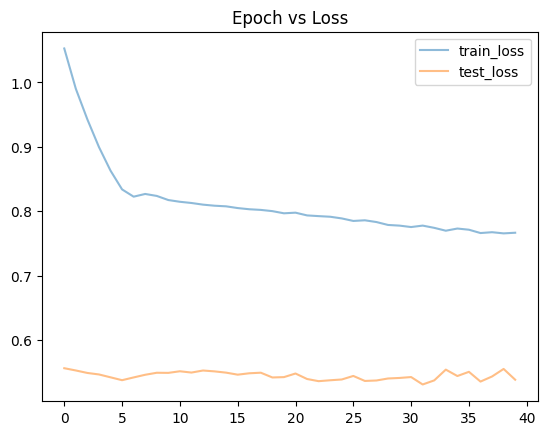

In [53]:
history = model.fit(X_train, y_train, validation_split=.1, epochs=40,
    verbose=1)

plotFitMetrics(history, "M01AB")

In [54]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 11ms/step - loss: 1.2041 - mae: 0.8192 - rmse: 1.0973 - r2: -0.2079


[1.2041068077087402,
 0.819183349609375,
 1.0973180532455444,
 -0.20789992809295654]

In [55]:
loss, mae, rmse, r2 = model.evaluate(X_test, y_test)
print(" RMSE        : ", rmse)
print(" MAE         : ", mae)
print(" R2-score    : ", r2)

2/2 [==============================] - 0s 12ms/step - loss: 1.2041 - mae: 0.8192 - rmse: 1.0973 - r2: -0.2079
 RMSE        :  1.0973180532455444
 MAE         :  0.819183349609375
 R2-score    :  -0.20789992809295654


In [56]:
preds = model.predict(X_test)

2/2 [==============================] - 0s 7ms/step


In [57]:
error = mean_squared_error(y_test, preds)
perror = mean_absolute_percentage_error(y_test, preds)

error, perror

(1.204106880431067, 276.6629927690364)

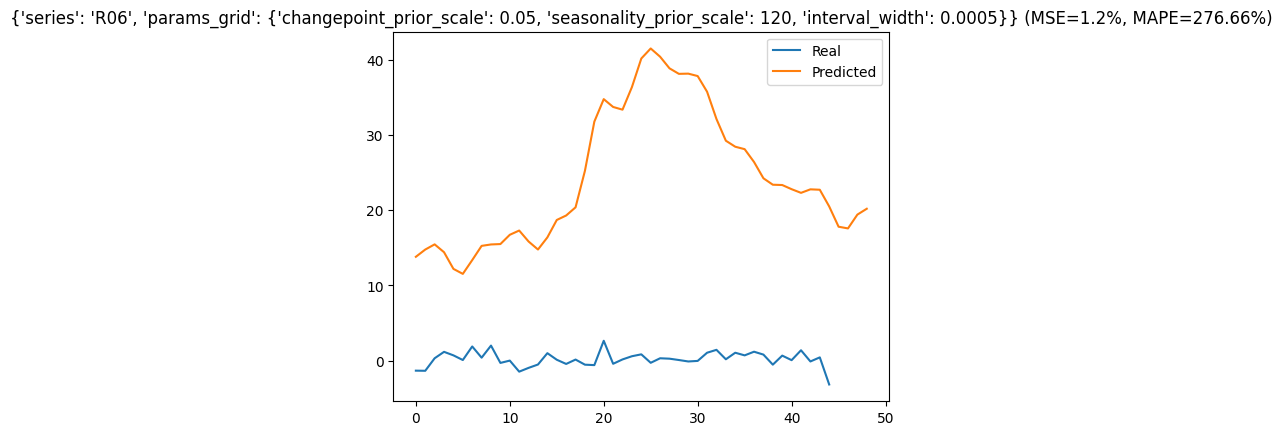

In [58]:
# plot the prediction vs actual
title = "{} (MSE={}%, MAPE={}%)".format(x, round(error, 2), round(perror, 2))
plt.title(title)

plt.plot(y_test, label='Real')
plt.plot(predictions, label='Predicted')
plt.legend()

plt.show()

# Expand it for all the rows



 #### For attribute M01AB #####
Metrics after training for 40 epoches
2/2 [==============================] - 0s 12ms/step - loss: 82.5562 - mae: 6.6093 - rmse: 9.0860 - r2: -0.1190
     RMSE        :  9.08604621887207
     MAE         :  6.609323501586914
     R2-score    :  -0.11900496482849121


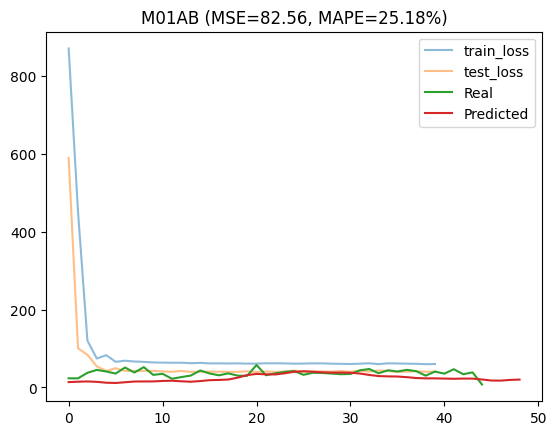



 #### For attribute M01AE #####
Metrics after training for 40 epoches
2/2 [==============================] - 0s 12ms/step - loss: 95.8200 - mae: 7.6326 - rmse: 9.7888 - r2: 0.0930
     RMSE        :  9.788769721984863
     MAE         :  7.632568836212158
     R2-score    :  0.0929945707321167


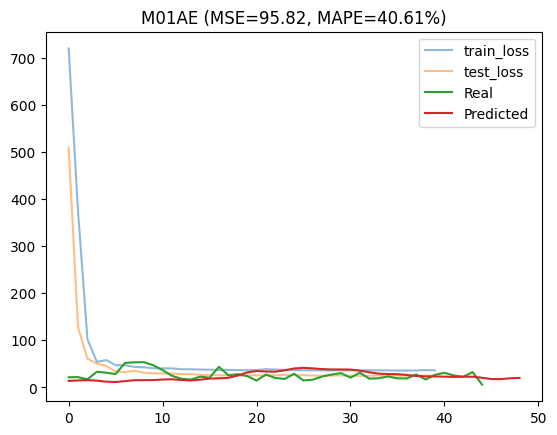



 #### For attribute N02BA #####
Metrics after training for 40 epoches
2/2 [==============================] - 0s 17ms/step - loss: 41.1383 - mae: 5.1612 - rmse: 6.4139 - r2: -0.4140
     RMSE        :  6.41391658782959
     MAE         :  5.161204814910889
     R2-score    :  -0.41404247283935547


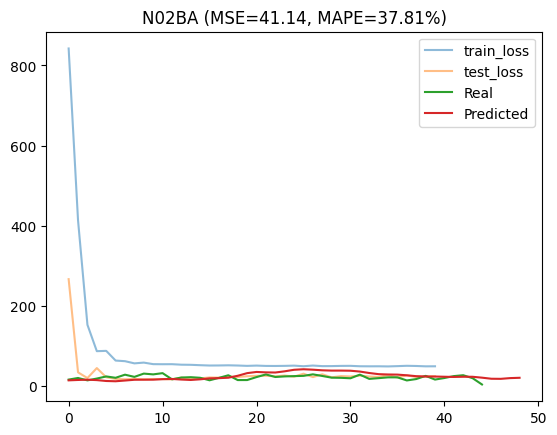



 #### For attribute N02BE #####
Metrics after training for 40 epoches
2/2 [==============================] - 0s 11ms/step - loss: 2848.8215 - mae: 38.4691 - rmse: 53.3744 - r2: 0.6157
     RMSE        :  53.374351501464844
     MAE         :  38.46908950805664
     R2-score    :  0.6157071590423584


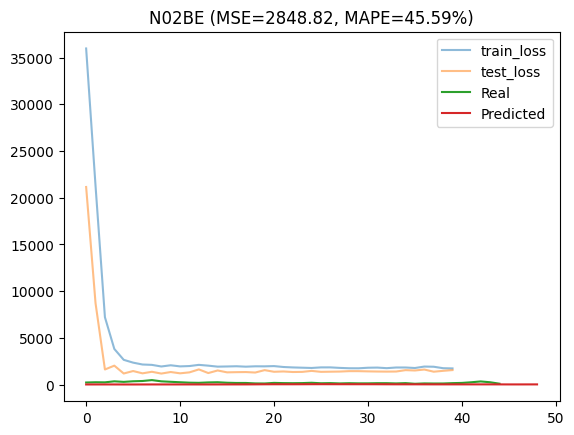



 #### For attribute N05B #####
Metrics after training for 40 epoches
2/2 [==============================] - 0s 17ms/step - loss: 157.7977 - mae: 9.8621 - rmse: 12.5618 - r2: -0.0222
     RMSE        :  12.561755180358887
     MAE         :  9.862075805664062
     R2-score    :  -0.022166728973388672


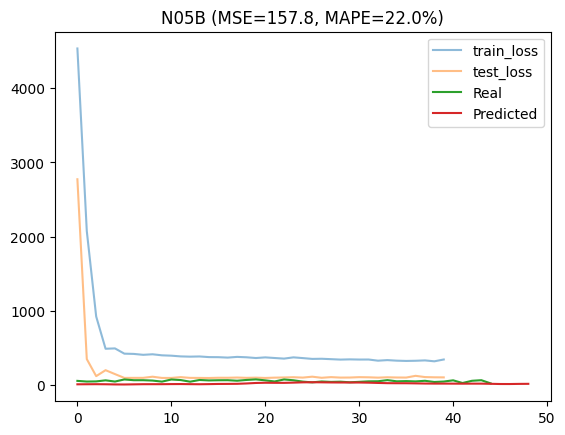



 #### For attribute N05C #####
Metrics after training for 40 epoches
2/2 [==============================] - 0s 13ms/step - loss: 8.5134 - mae: 2.3454 - rmse: 2.9178 - r2: -0.0932
     RMSE        :  2.917764902114868
     MAE         :  2.3453776836395264
     R2-score    :  -0.09318554401397705


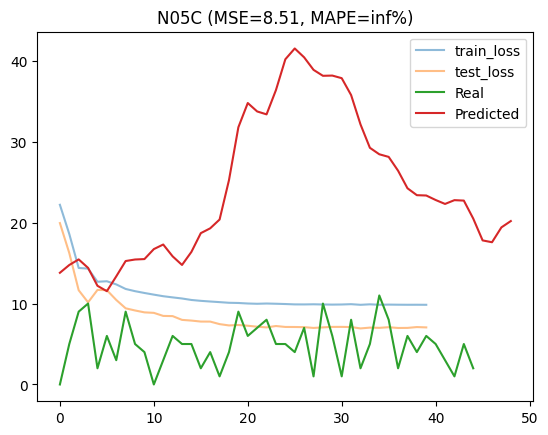



 #### For attribute R03 #####
Metrics after training for 40 epoches
2/2 [==============================] - 0s 19ms/step - loss: 938.5880 - mae: 23.4775 - rmse: 30.6364 - r2: -0.0506
     RMSE        :  30.636383056640625
     MAE         :  23.47753143310547
     R2-score    :  -0.05055952072143555


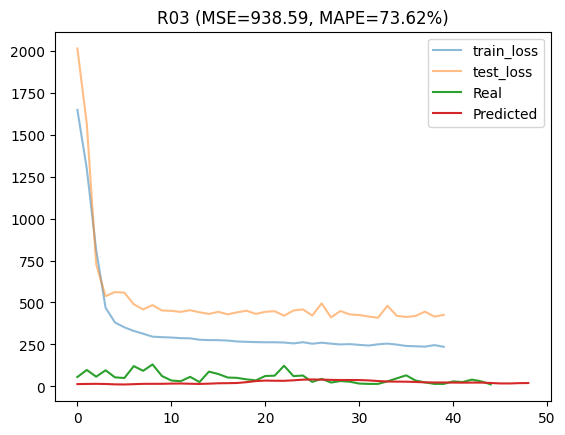



 #### For attribute R06 #####
Metrics after training for 40 epoches
2/2 [==============================] - 0s 15ms/step - loss: 67.7624 - mae: 6.0793 - rmse: 8.2318 - r2: 0.6029
     RMSE        :  8.231791496276855
     MAE         :  6.07928466796875
     R2-score    :  0.6029424071311951


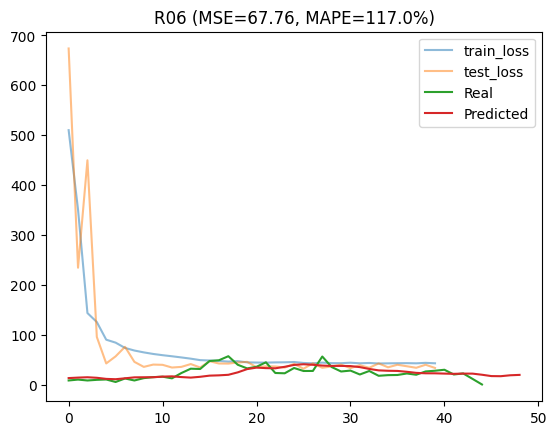

In [59]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')


cols = ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']

for x in cols:
    X=df[x].values

    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((len(X_test), n_steps, n_features))

    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics= metrics)

    print(f"\n\n #### For attribute {x} #####")

    history = model.fit(X_train, y_train, validation_split=.1, epochs=40,
        verbose=0)

    print("Metrics after training for 40 epoches")

    loss, mae, rmse, r2 = model.evaluate(X_test, y_test)
    print("     RMSE        : ", rmse)
    print("     MAE         : ", mae)
    print("     R2-score    : ", r2)

    plotFitMetrics(history, x)

    preds = model.predict(X_test, verbose=0)

    error = mean_squared_error(y_test, preds)
    perror = mean_absolute_percentage_error(y_test, preds)

    plt.title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')

    plt.plot(y_test, label='Real')
    plt.plot(predictions, label='Predicted')
    plt.legend()

    plt.show()



####  Long-term forecasting with Stacked LSTM model

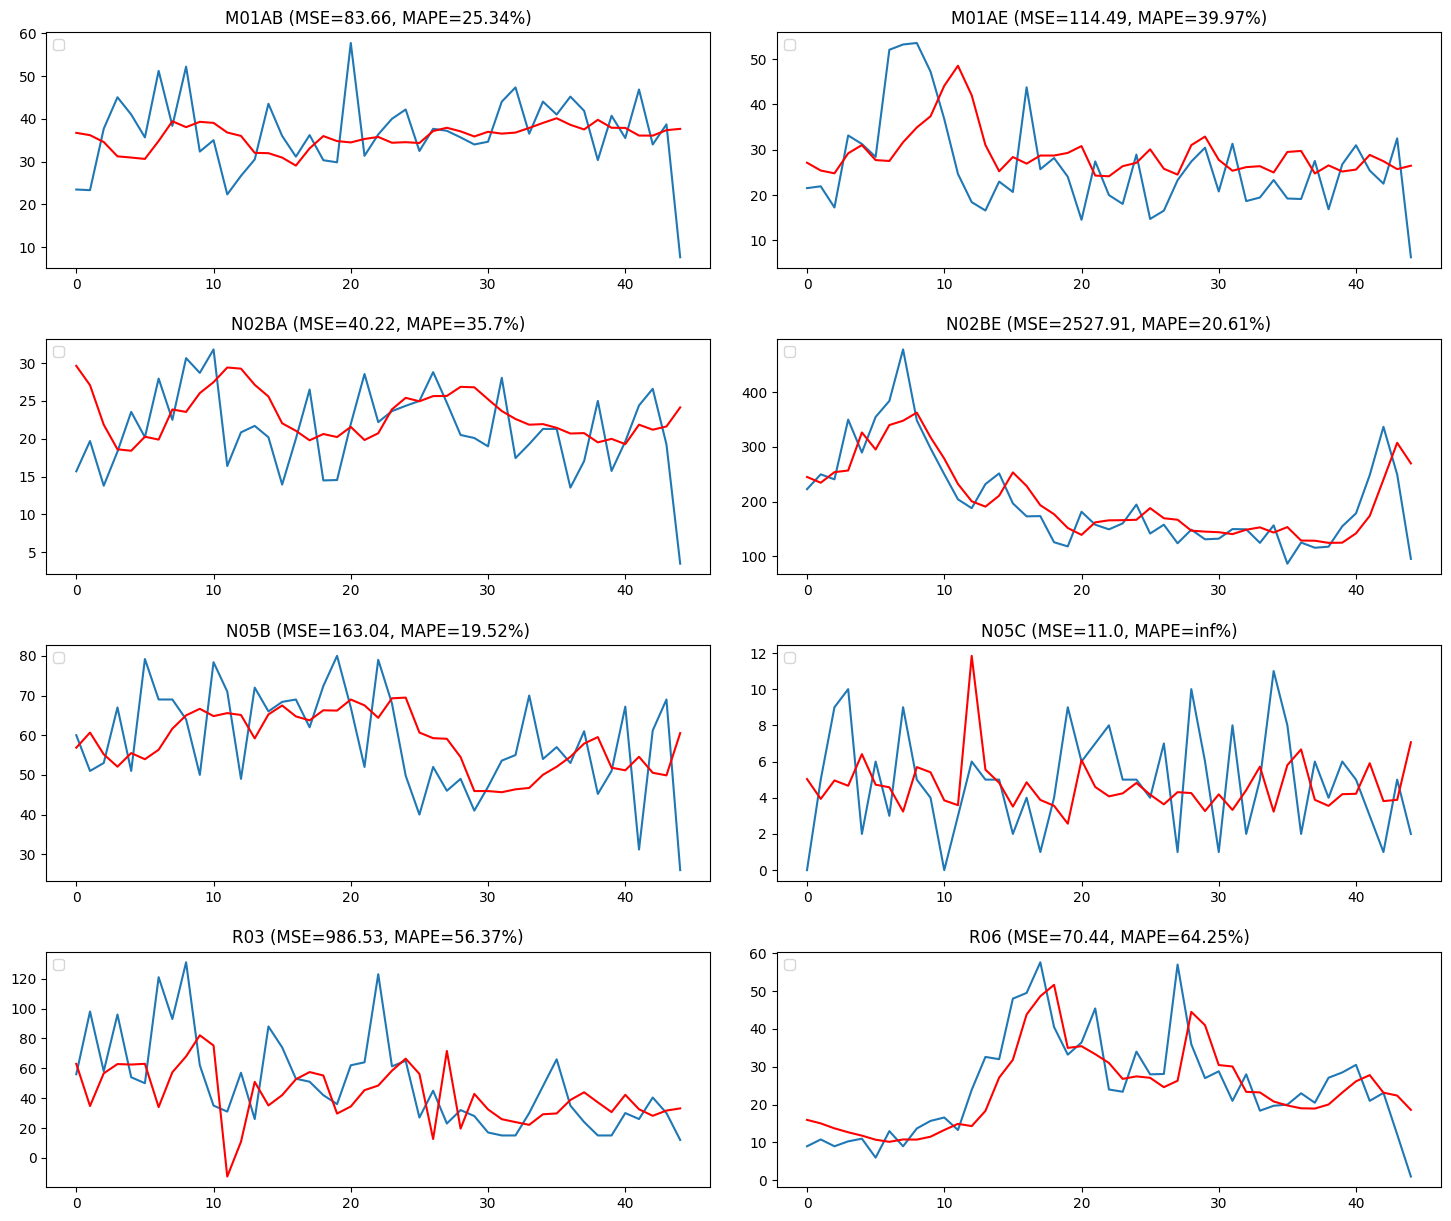

In [60]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Stacked LSTM MSE',x]=error
    resultsLongtermdf.loc['Stacked LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()



```
```

####  Long-term forecasting with Bidirectional LSTM

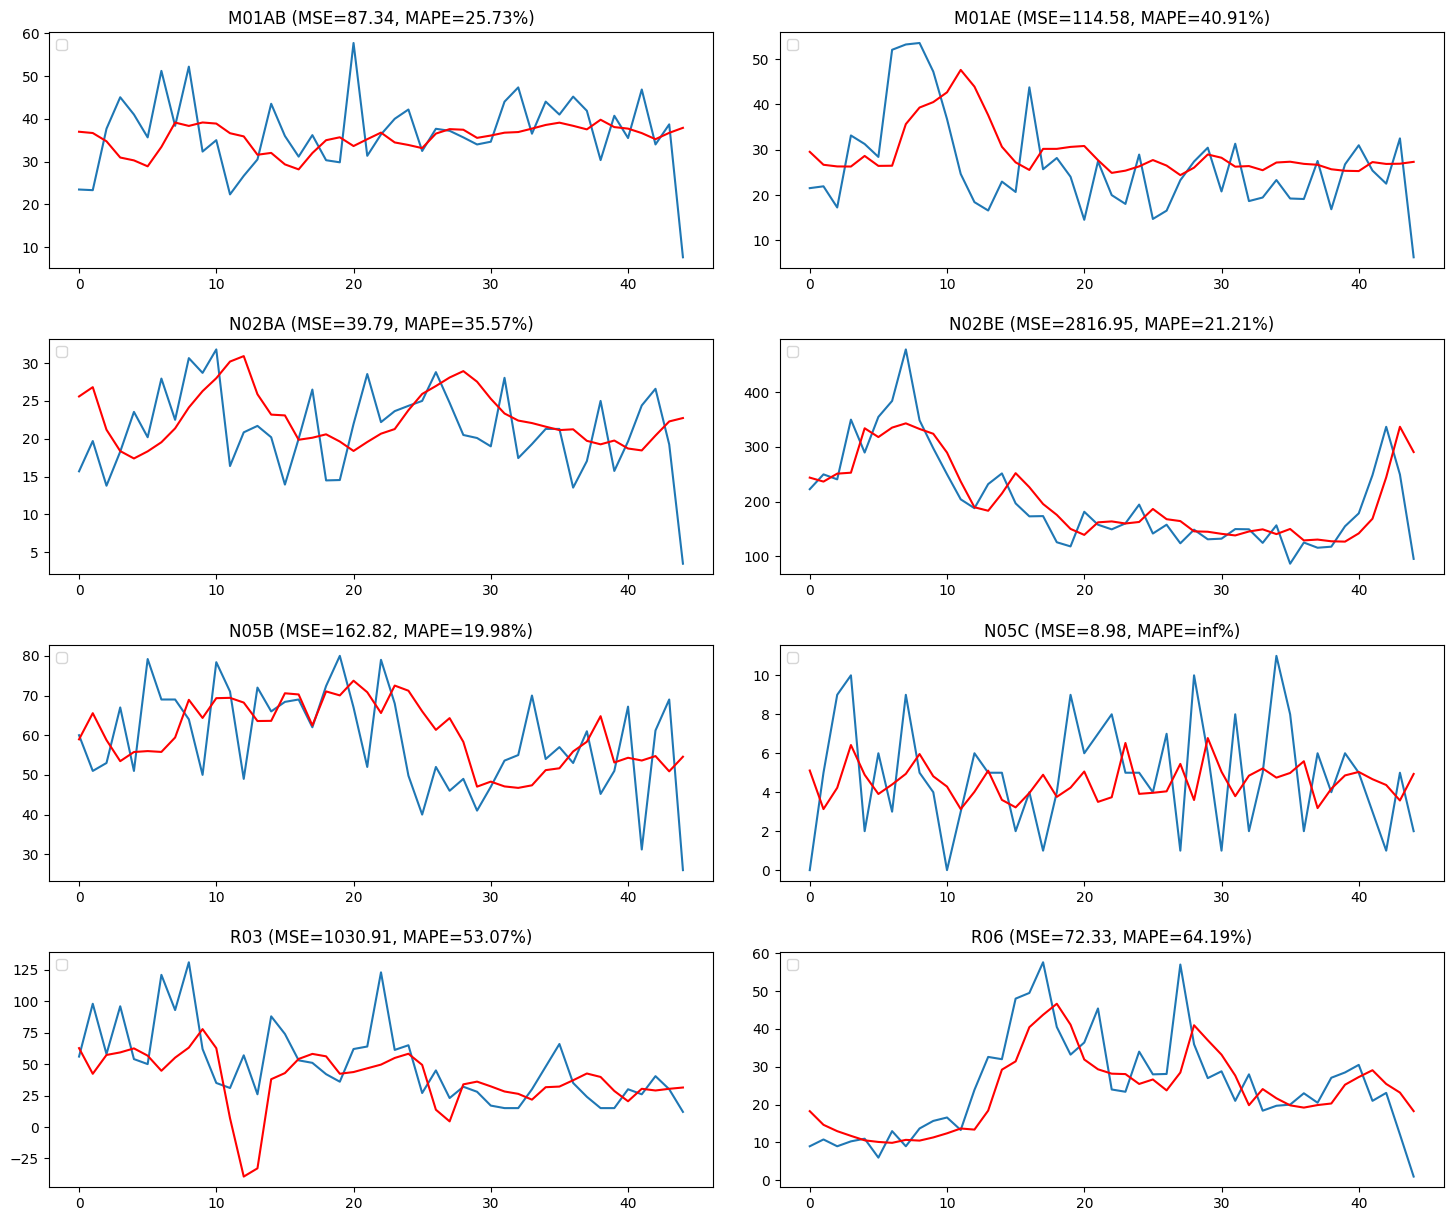

In [61]:
df=pd.read_csv('/content/gdrive/MyDrive/pharma-sales/dataset/salesweekly.csv')

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Bidirectional LSTM MSE',x]=error
    resultsLongtermdf.loc['Bidirectional LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

In [62]:
from IPython.display import display, HTML
display(HTML(resultsRollingdf.to_html()))

In [63]:
from IPython.display import display, HTML
display(HTML(resultsLongtermdf.to_html()))